<a href="https://colab.research.google.com/github/yolo-wjc/DL_homework/blob/main/DL_homework_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用 GARCH 和多元 LSTM 实现比特币波动率预测


该项目基于 **GARCH** 和 **LSTM 神经网络**。**预测未来 7 天的 BTC-USD 每日平均已实现波动率（RV）**

波动性试图衡量标的资产在一定时期内经历的价格变动的幅度。 该标的的价格波动越剧烈，波动水平就越高，反之亦然。

波动率被普遍认为是市场风险的最佳衡量标准，波动率预测被用于整个行业的许多不同应用。 **已实现波动率预测**模型通常用于风险管理、做市、投资组合优化和期权交易。许多交易策略围绕识别发生这种波动性不匹配的情况而发展：

\begin{align*}
P/L = Vega|\sigma_{implied} - \sigma_{realized}|
\end{align*}

其中Vega是衡量期权价格对标的资产波动性变化的敏感度，$\sigma$是波动性。
由于隐含波动率 (IV) 可以使用布莱克斯科尔斯模型等模型从期权价格中得出，因此预测已实现波动率将为我们提供方程式第二部分的关键。

尽管波动率的预测和建模一直是学术界许多实证研究和理论研究的焦点，但准确预测波动率仍然是学者们面临的一个重大挑战。 最重要的是，由于加密期权交易相对较新，因此对比特币波动性预测进行的研究并不多。 此外，加密货币与传统受监管股票和大宗商品存在某些细微差别，也需要加以考虑。

比特币开盘价/收盘价/最高价/最低价的历史数据集是使用雅虎财经 API **`yfinance`** 获得的。使用代码“BTC-USD”每隔 1 天下载一次 BTC-USD 价格。 雅虎直到 2014 年才添加比特币； 因此，尽管它于 2009 年首次交易，但 **`yfinance`** 仅包含 2014 年 9 月至今（2023 年 11 月）的数据。 因此我们将获得3000 多个数据点，涵盖约 9 年的交易日。

### 导入依赖库

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pd.set_option('display.max_colwidth', None)

### 从 `yfinance` 加载数据

In [ ]:
seed = 2021
start = datetime(2014, 1, 1)
end = datetime(2023, 11, 21)
tckr = 'BTC-USD'
ticker = yf.Ticker(tckr)
df = ticker.history(start=start,end=end,interval="1d")

In [ ]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             Volume  Dividends  Stock Splits  
Date                                                          
2014-09-17 00:00:00+00:00  21056800        0.0           0.0  
2014-09-18 00:00:00+00:00  34483200        0.0           0.0  
2014-09-19 00:00:00+00:00  37919700        0.0           0.0  
2014-09-20 00:00:00+00:00  36863600        0.0           0.0  
2014-09-21 00:00:00+00:00  26580100        0.0           0.0

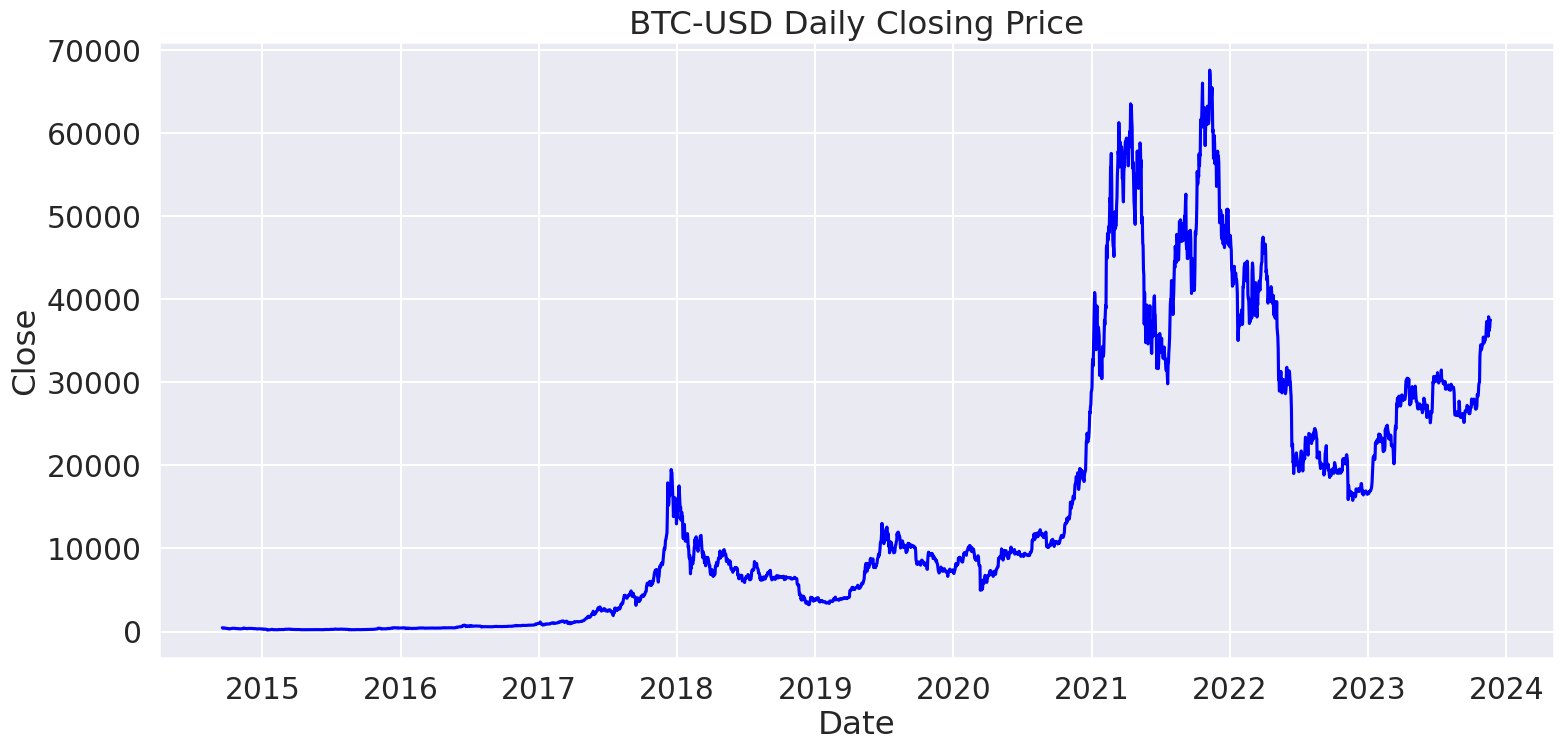

In [ ]:
sns.set_context("talk", font_scale=1.3)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')


### 波动性的类型及其测量方法


“波动性并不能衡量价格变化的方向，而只能衡量价格变化的分散程度。 这是因为在计算标准差（或方差）时，所有差值均被平方，因此负差值和正差值合并为一个量。 具有不同波动性的两种工具可能具有相同的预期回报，但波动性较高的工具在给定时间内的价值波动会更大。” --- 维基百科

波动性可以是历史波动性，也可以是隐含波动性； 两者通常都以百分比表示。

     历史波动率 (HV) 或已实现波动率是标的资产在一段时间内（例如过去一个月或一年）表现出的实际波动率。
     已实现波动率(RV)通常计算为价格回报的标准差，即美元价格变化占前一天价格的百分比。
     隐含波动率（IV）是当前期权价格隐含的标的物的波动水平。

In [ ]:
df['returns'] = 100 * df.Close.pct_change().dropna()
df['log_returns'] = np.log(df.Close/df.Close.shift(1))
df.dropna(inplace=True)

In [ ]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   
2014-09-22 00:00:00+00:00  399.100006  406.915985  397.130005  402.152008   

                             Volume  Dividends  Stock Splits   returns  \
Date                                                                     
2014-09-18 00:00:00+00:00  34483200        0.0           0.0 -7.192558   
2014-09-19 00:00:00+00:00  37919700        0.0           0.0 -6.984265   
2014-09-20 00:00:00+00:00  36863600        0.0           0.0  3.573492   
2014-09-21 00:00:00+00:00  26580100        0.0           0.0 -2.465854   
2014-09-22 00:00:00+00:00  24127600        0.0           0.0  0.835210   

                           log_returns  
Date                                    
2014-09-18 00:00:00+00:00    -0.074643  
2014-09-19 00:00:00+00:00    -0.072402  
2014-09-20 00:00:00+00:00     0.035111  
2014-09-21 00:00:00+00:00    -0.024968  
2014-09-22 00:00:00+00:00     0.008317

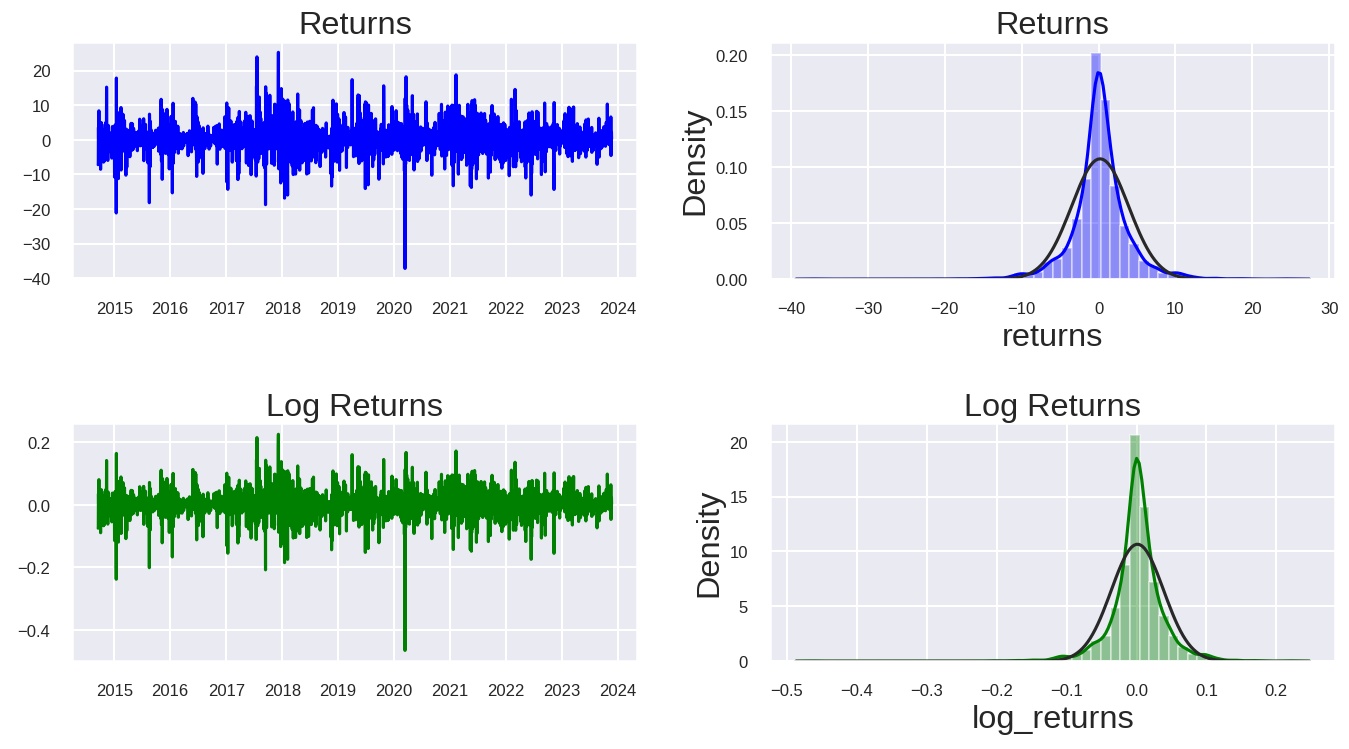

In [ ]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')
    axes[0][0].tick_params(labelsize=12)


    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')
    axes[0][1].tick_params(labelsize=12)

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')
    axes[1][0].tick_params(labelsize=12)

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    axes[1][1].tick_params(labelsize=12)
    plt.tight_layout()
    fig.show();

不难发现比特币收益率的两个性质:
- 左偏（与股票相反）
- 尖峰厚尾


In [ ]:
df.returns.describe()

count    3351.000000
mean        0.201088
std         3.712360
min       -37.169539
25%        -1.272740
50%         0.131961
75%         1.709828
max        25.247169
Name: returns, dtype: float64

In [ ]:
df.log_returns.describe()

count    3351.000000
mean        0.001315
std         0.037416
min        -0.464730
25%        -0.012809
50%         0.001319
75%         0.016954
max         0.225119
Name: log_returns, dtype: float64

对于较长或较短间隔内计算的对数回报，标准差将有所不同。 在这里某个固定时间窗口（INTERVAL_WINDOW）的波动性是对数收益的标准差，或者是对数收益平方和的平方根：

$\sigma_{间隔} = \sqrt{\sum_{t} r_{t-1, t}^2}$

然后，要将每日波动率按特定频率（每周、每月、每年）进行缩放，例如：

$\sigma_{每日} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{年化} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{每月} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{每周} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [ ]:
def realized_volatility_daily(series_log_return):

    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

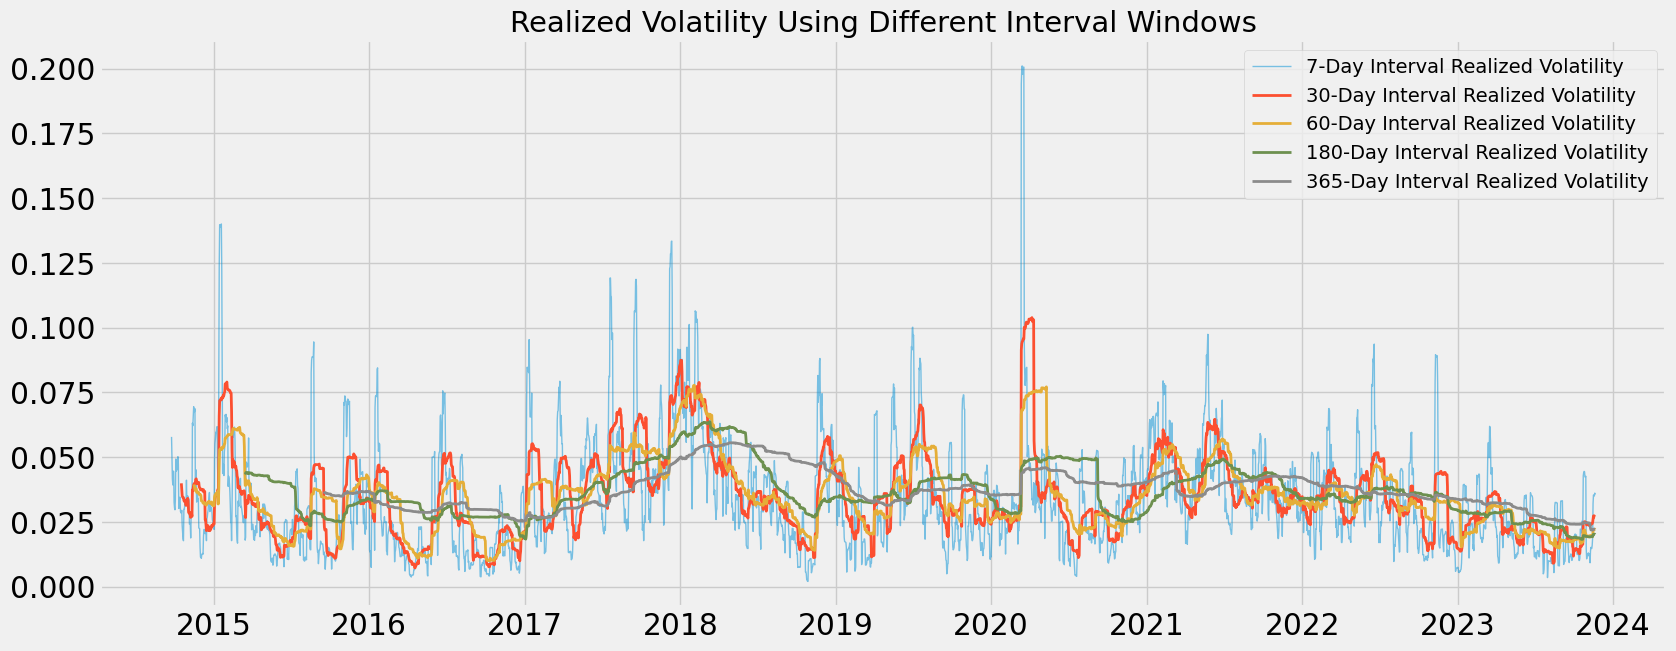

In [ ]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

for i in intervals:

    vols = df.log_returns.rolling(window=i).apply(realized_volatility_daily).values
    vols_df[i] = vols

vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility',
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})

plt.show();

这里选择 30 天的原因是因为 7 天太嘈杂，无法观察到有意义的模式和规律，而较长的时间窗口可以显著降低波动性而且还有助于避免在数据集开始时浪费太多数据点。

时间序列预测模型是能够根据之前观察到的值预测**未来**值的模型。 在这种情况下，目标“**未来**”数据是通过将当前波动率向后移动**“n_future”**滞后数来获得的。例如，相对于上周的星期一，本周的星期一是“**未来**”； 因此，我只需要将本周的波动性向后移 7 天，并将其用作上周所需的“**未来**”输出，然后将其用于神经网络训练和模型性能评估。

In [ ]:
INTERVAL_WINDOW = 30
n_future = 7

df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW).apply(realized_volatility_daily)
df['vol_future'] = df.log_returns.shift(-n_future).rolling(window=INTERVAL_WINDOW).apply(realized_volatility_daily)

In [ ]:
df.describe()

Open          High           Low         Close        Volume  \
count   3351.000000   3351.000000   3351.000000   3351.000000  3.351000e+03   
mean   14250.759206  14586.908879  13887.173520  14260.452219  1.648460e+10   
std    16012.297245  16401.986888  15572.673489  16012.470882  1.917650e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      897.538513    911.872498    872.242004    898.947510  1.476180e+08   
50%     8161.935547   8290.330078   7931.100098   8165.009766  1.097279e+10   
75%    23094.459961  23472.067383  22701.054688  23127.910156  2.696132e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

       Dividends  Stock Splits      returns  log_returns  vol_current  \
count     3351.0        3351.0  3351.000000  3351.000000  3322.000000   
mean         0.0           0.0     0.201088     0.001315     0.034562   
std          0.0           0.0     3.712360     0.037416     0.016017   
min          0.0           0.0   -37.169539    -0.464730     0.007228   
25%          0.0           0.0    -1.272740    -0.012809     0.023655   
50%          0.0           0.0     0.131961     0.001319     0.032443   
75%          0.0           0.0     1.709828     0.016954     0.043304   
max          0.0           0.0    25.247169     0.225119     0.103878   

        vol_future  
count  3315.000000  
mean      0.034560  
std       0.016034  
min       0.007228  
25%       0.023647  
50%       0.032390  
75%       0.043316  
max       0.103878

两列 `Dividends` 和 `Stock Splits` 不存储任何信息，所有行都是“0.0”，所以删除它们。

In [ ]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [ ]:
df.describe()

Open          High           Low         Close        Volume  \
count   3351.000000   3351.000000   3351.000000   3351.000000  3.351000e+03   
mean   14250.759206  14586.908879  13887.173520  14260.452219  1.648460e+10   
std    16012.297245  16401.986888  15572.673489  16012.470882  1.917650e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      897.538513    911.872498    872.242004    898.947510  1.476180e+08   
50%     8161.935547   8290.330078   7931.100098   8165.009766  1.097279e+10   
75%    23094.459961  23472.067383  22701.054688  23127.910156  2.696132e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3351.000000  3351.000000  3322.000000  3315.000000  
mean      0.201088     0.001315     0.034562     0.034560  
std       3.712360     0.037416     0.016017     0.016034  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.272740    -0.012809     0.023655     0.023647  
50%       0.131961     0.001319     0.032443     0.032390  
75%       1.709828     0.016954     0.043304     0.043316  
max      25.247169     0.225119     0.103878     0.103878

由于我当前使用的“INTERVAL_WINDOW”为 30，“n_future”为 7，因此数据集的前 30 个值以及最后 7 个值的波动率将为“NaN”，因此需要从数据集中删除。

In [ ]:
df.dropna(inplace=True)

## **EDA**
首先，我将根据当前波动率“vol_current”绘制出我想要的目标输出“vol_future”。 第一个图显示了我拥有的涵盖 7 年的所有样本，但第二个图仅放大了最近 1 年的情况。

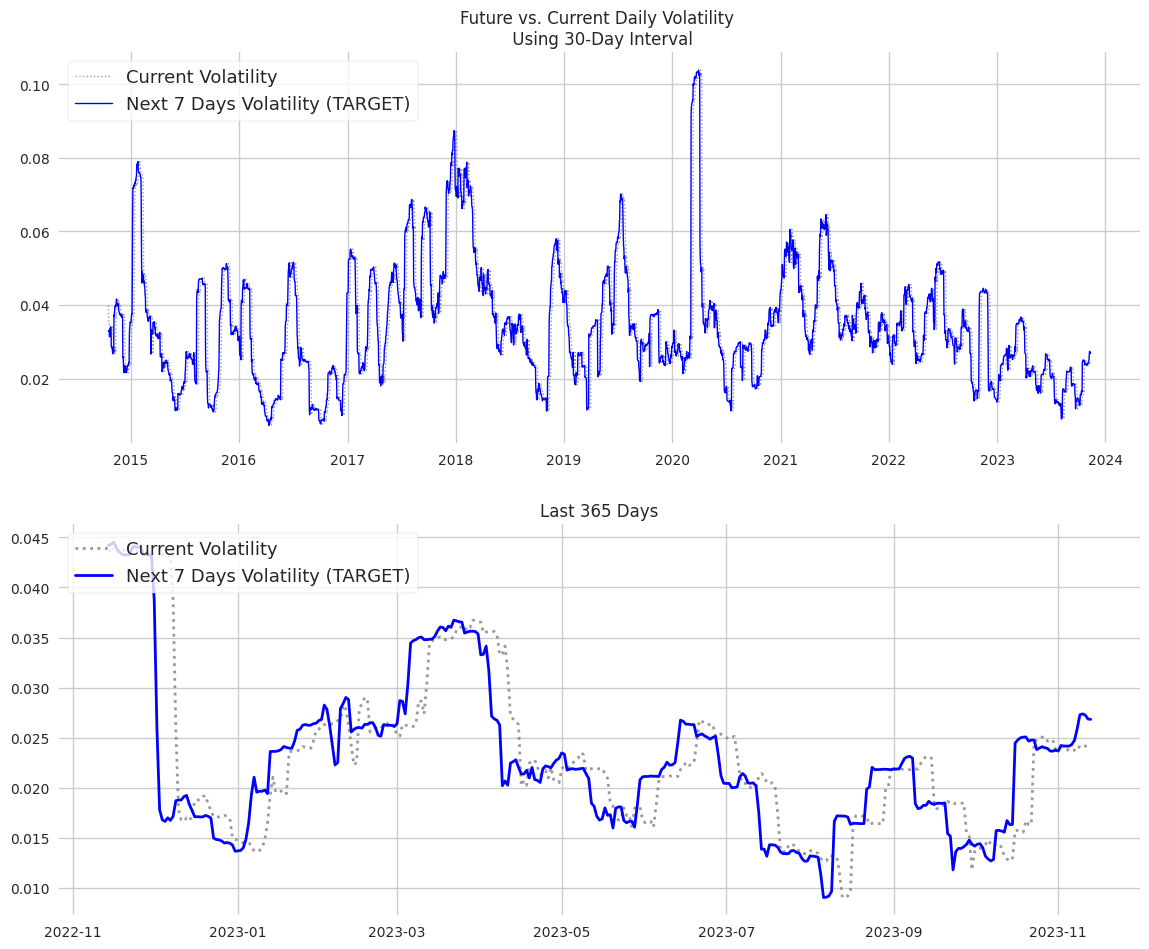

In [ ]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
plt.style.use(['seaborn'])

with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()

    plt.show();

### **按月分组的每日波动率**

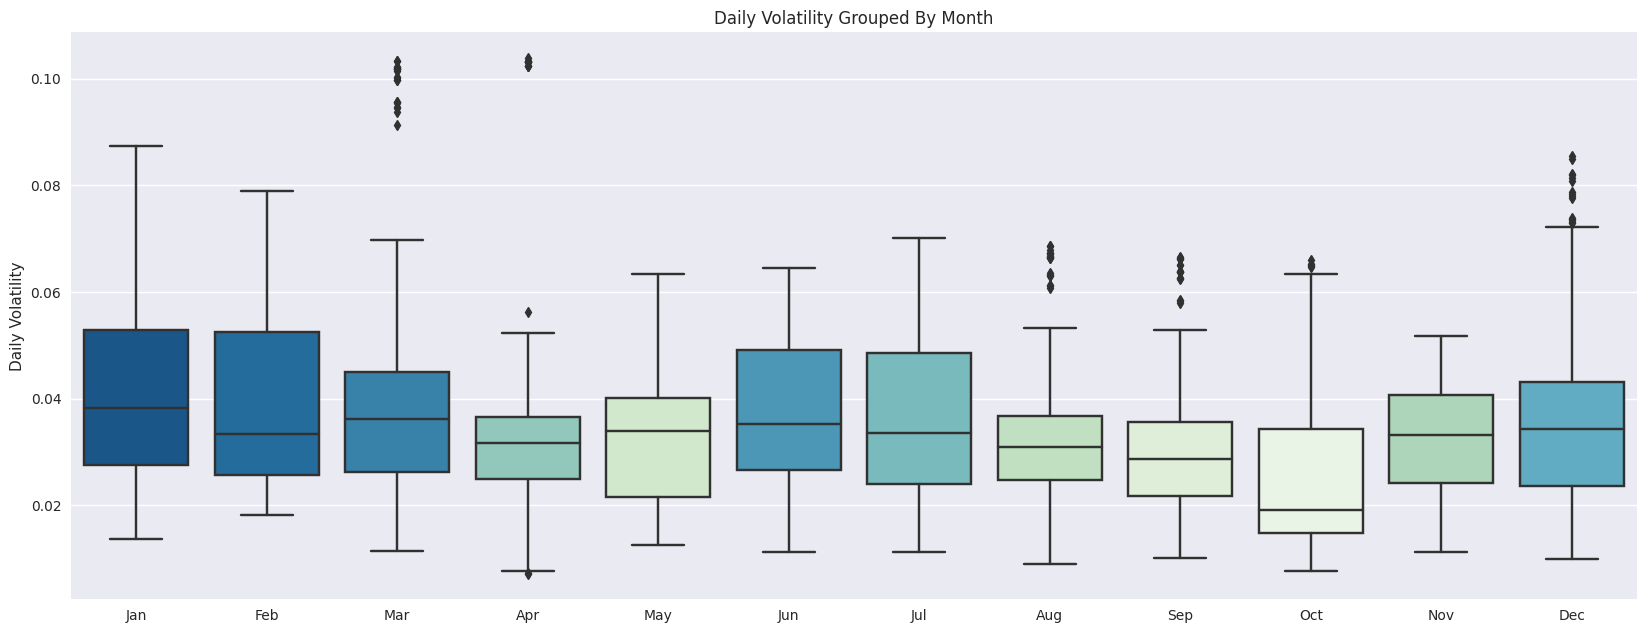

In [ ]:
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun',
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

data = df.groupby(by=[df.index.month_name()]).vol_current.mean()

data.index = [x[:3] for x in data.index]

pal = sns.color_palette("GnBu", len(data))

rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=[x[:3] for x in df.index.month_name()],
                y=df.vol_current,
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Month')
    plt.show()

In [ ]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06 00:00:00+00:00    0.103878
2020-04-03 00:00:00+00:00    0.103330
2020-04-02 00:00:00+00:00    0.103319
2020-03-30 00:00:00+00:00    0.103302
2020-03-31 00:00:00+00:00    0.103300
2020-04-01 00:00:00+00:00    0.103203
2020-04-05 00:00:00+00:00    0.103192
2020-04-04 00:00:00+00:00    0.103175
2020-04-10 00:00:00+00:00    0.103052
2020-04-07 00:00:00+00:00    0.102421
2020-04-09 00:00:00+00:00    0.102414
2020-04-08 00:00:00+00:00    0.102411
2020-03-29 00:00:00+00:00    0.102179
2020-03-24 00:00:00+00:00    0.102140
2020-03-25 00:00:00+00:00    0.102018
2020-03-23 00:00:00+00:00    0.101864
2020-03-26 00:00:00+00:00    0.101844
2020-03-28 00:00:00+00:00    0.101738
2020-03-27 00:00:00+00:00    0.101523
2020-03-22 00:00:00+00:00    0.100300
2020-03-19 00:00:00+00:00    0.100166
2020-03-20 00:00:00+00:00    0.099710
2020-03-21 00:00:00+00:00    0.099709
2020-03-17 00:00:00+00:00    0.095724
2020-03-18 00:00:00+00:00    0.095614
2020-03-16 00:00:00+00:00    0.095421
2020-03

可以看出：
- 波动率在 12 月和 1 月历史上达到了一些较高点
- 3 月和 4 月的异常值最多
- 而 6 月和 11 月历史上相对平静


### **按年分组的每日波动率**

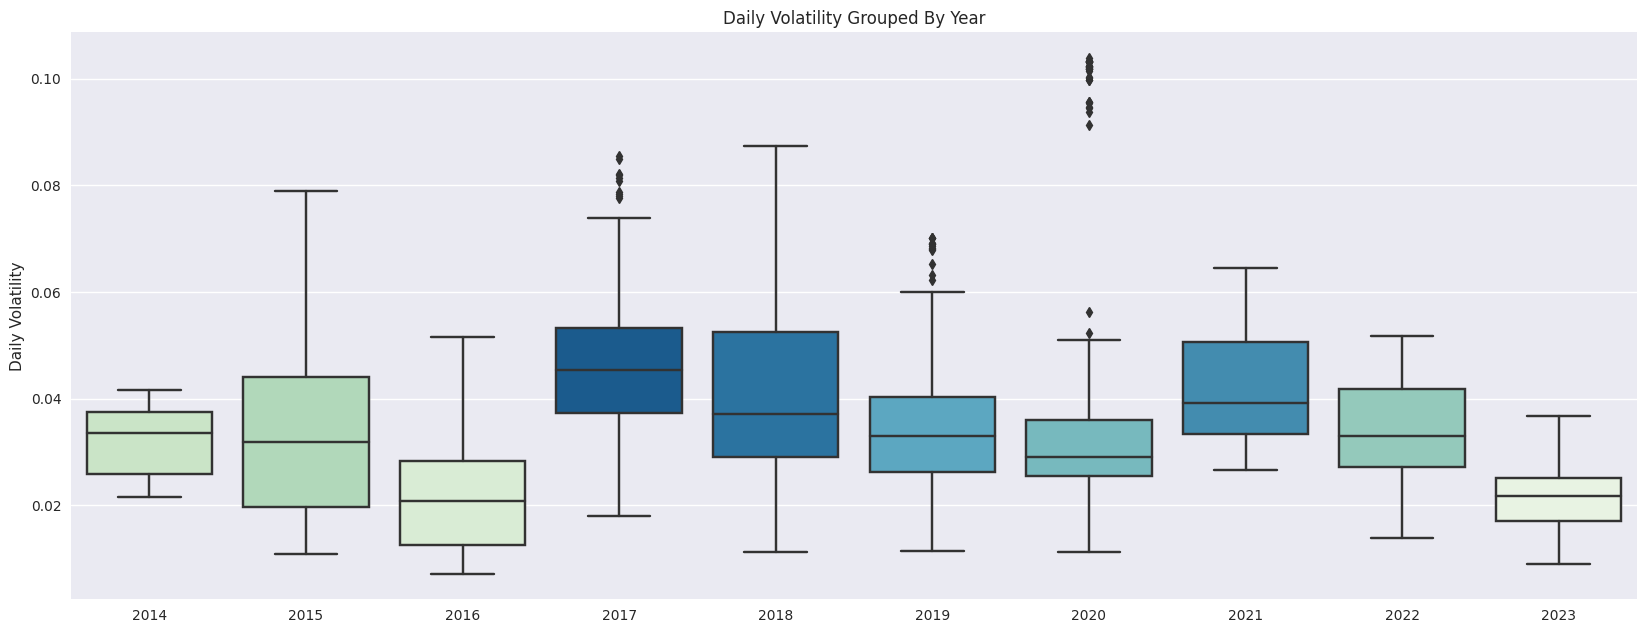

In [ ]:
data = df.groupby(by=[df.index.year]).vol_current.mean()

pal = sns.color_palette("GnBu", len(data))

rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=df.index.year,
                y=df.vol_current,
                palette=np.array(pal)[rank])
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Year')
    plt.show()

几年前加密货币市场经历了一些巨大的结构性变化，这些变化直接影响了波动性，例如：
- 加密货币期权于 2016 年在 Deribit 上可用
- 2017 年 CME 推出比特币期货
- 2020 年 CME 比特币期权



### **每日波动率的分布**

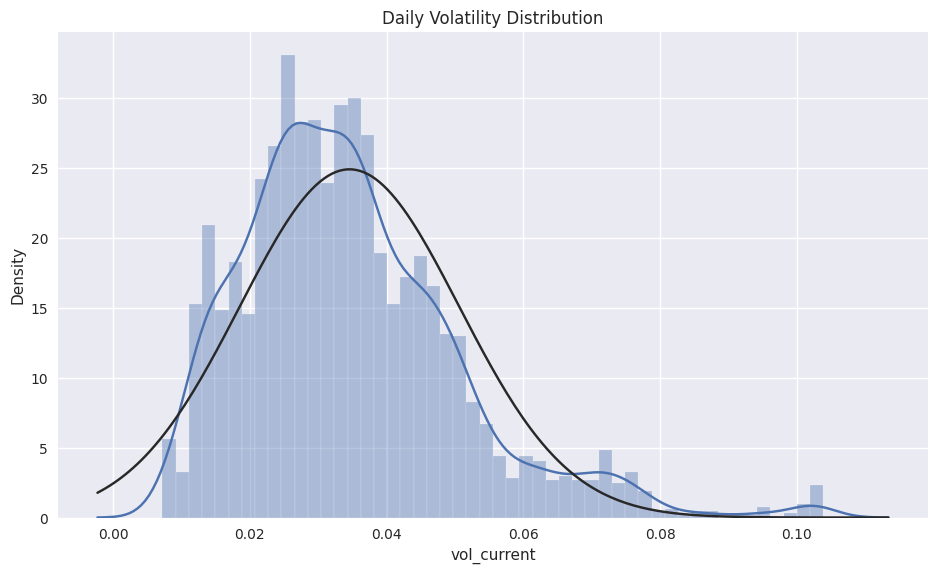

In [ ]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.show();

每日已实现波动率的分布略微右偏，少数较大值稀疏地分布在右侧。

note：右偏分布的中位数小于平均值，众数小于中位数（众数 < 中位数 < 平均值）。

### **收益率平稳性检验**



In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -17.411592406199368
p-value: 4.882351045094927e-30
Critical Values:
1%: -3.4323
5%: -2.8624
10%: -2.5672


In [ ]:
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -58.693663402673586
p-value: 0.0
Critical Values:
1%: -3.4323
5%: -2.8624
10%: -2.5672


使用 0.05 的显著性水平，收益率和对数收益率的“p 值”都显着小于 0.05，这意味着有足够的证据来拒绝原假设。

--> 平稳性

## **Train-Validation-Test Splits**

该数据集中涵盖从 2014 年 10 月到 2023 年 11 月） 9 年的时间。 由于加密货币不在受监管的交易所进行交易，因此比特币市场是 24/7 开放的，一年涵盖整整 365 个交易日，而不是像其他股票和大宗商品那样每年 252 天。

将数据集分为 3 部分，如下所示：
- 最近 30 个可用样本将作为 **测试集**
- 1年（365天）用于**验证集**
- 剩余的用于**训练集**

In [ ]:
test_size = 30
val_size = 365

split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-10-17 00:00:00+00:00 	to: 2022-10-14 00:00:00+00:00 	2920 days
VALIDATION 	From: 2022-10-15 00:00:00+00:00 	to: 2023-10-14 00:00:00+00:00 	365 days
TEST 		From: 2023-10-15 00:00:00+00:00 	to: 2023-11-13 00:00:00+00:00 	30 days


这里的标签是“vol_future”，它代表从今天起接下来的“n_future”天的每日已实现波动率（从“t + n_future - INTERVAL_WINDOW”到时间戳“t + n_future”的平均每日已实现波动率）。

例如这里设置“n_future”值为 7 和“INTERVAL_WINDOW”为 30，在时间戳“t”预测的值将是从时间步 `t-22` 到时间戳的平均每日已实现波动率 `t+7`。

In [ ]:
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [ ]:
y_train.describe()

count    2920.000000
mean        0.036114
std         0.016200
min         0.007228
25%         0.025414
50%         0.033861
75%         0.044695
max         0.103878
Name: vol_future, dtype: float64

In [ ]:
x_train.describe()

count    2920.000000
mean        0.036156
std         0.016175
min         0.007228
25%         0.025501
50%         0.033957
75%         0.044695
max         0.103878
Name: vol_current, dtype: float64

## **数据预处理**

### 1. 数据标准化

由于我们使用不同的模型作为对比，因此最好对波动率进行标准化再输入进模型生成预测结果。 这里使用`MinMaxScaler`缩放

In [ ]:
def transform_volatility_to_scaler(scaler, tf_series):

    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],index=idx)
    return output

In [ ]:
scaler_vol = MinMaxScaler()
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [ ]:
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [ ]:
x_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.039872
2014-10-18 00:00:00+00:00    0.037566
2014-10-19 00:00:00+00:00    0.035089
2014-10-20 00:00:00+00:00    0.034629
2014-10-21 00:00:00+00:00    0.034362
2014-10-22 00:00:00+00:00    0.034364
2014-10-23 00:00:00+00:00    0.033347
2014-10-24 00:00:00+00:00    0.032900
2014-10-25 00:00:00+00:00    0.033009
2014-10-26 00:00:00+00:00    0.033083
Name: vol_current, dtype: float64

In [ ]:
y_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.032900
2014-10-18 00:00:00+00:00    0.033009
2014-10-19 00:00:00+00:00    0.033083
2014-10-20 00:00:00+00:00    0.033017
2014-10-21 00:00:00+00:00    0.031334
2014-10-22 00:00:00+00:00    0.033474
2014-10-23 00:00:00+00:00    0.033426
2014-10-24 00:00:00+00:00    0.033602
2014-10-25 00:00:00+00:00    0.034075
2014-10-26 00:00:00+00:00    0.033154
Name: vol_future, dtype: float64

In [ ]:
x_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.337754
2014-10-18 00:00:00+00:00    0.313894
2014-10-19 00:00:00+00:00    0.288269
2014-10-20 00:00:00+00:00    0.283501
2014-10-21 00:00:00+00:00    0.280738
2014-10-22 00:00:00+00:00    0.280764
2014-10-23 00:00:00+00:00    0.270238
2014-10-24 00:00:00+00:00    0.265613
2014-10-25 00:00:00+00:00    0.266743
2014-10-26 00:00:00+00:00    0.267507
dtype: float64

In [ ]:
y_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.265613
2014-10-18 00:00:00+00:00    0.266743
2014-10-19 00:00:00+00:00    0.267507
2014-10-20 00:00:00+00:00    0.266830
2014-10-21 00:00:00+00:00    0.249415
2014-10-22 00:00:00+00:00    0.271550
2014-10-23 00:00:00+00:00    0.271058
2014-10-24 00:00:00+00:00    0.272883
2014-10-25 00:00:00+00:00    0.277768
2014-10-26 00:00:00+00:00    0.268242
dtype: float64

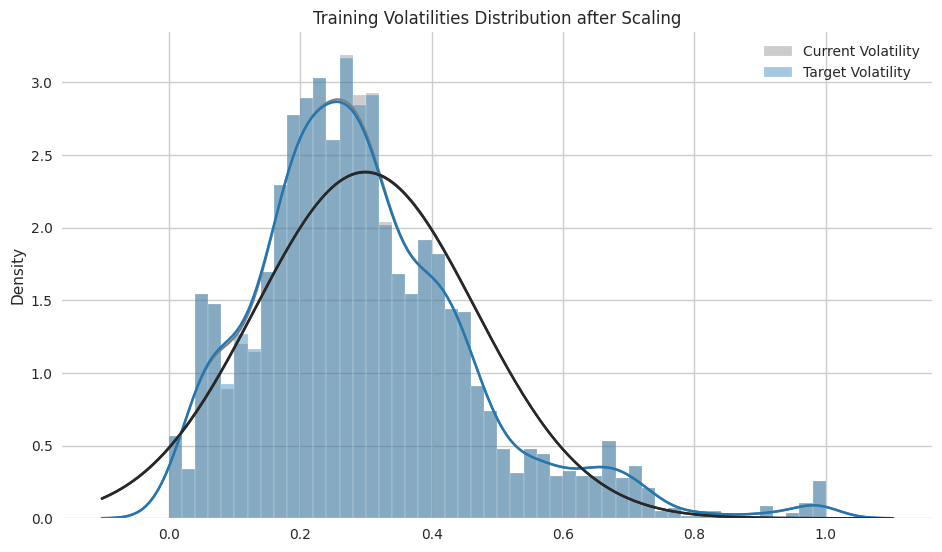

In [ ]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm,
                 color='gray',
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue',
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show();

### **2. 训练集-验证集-测试集的可视化**

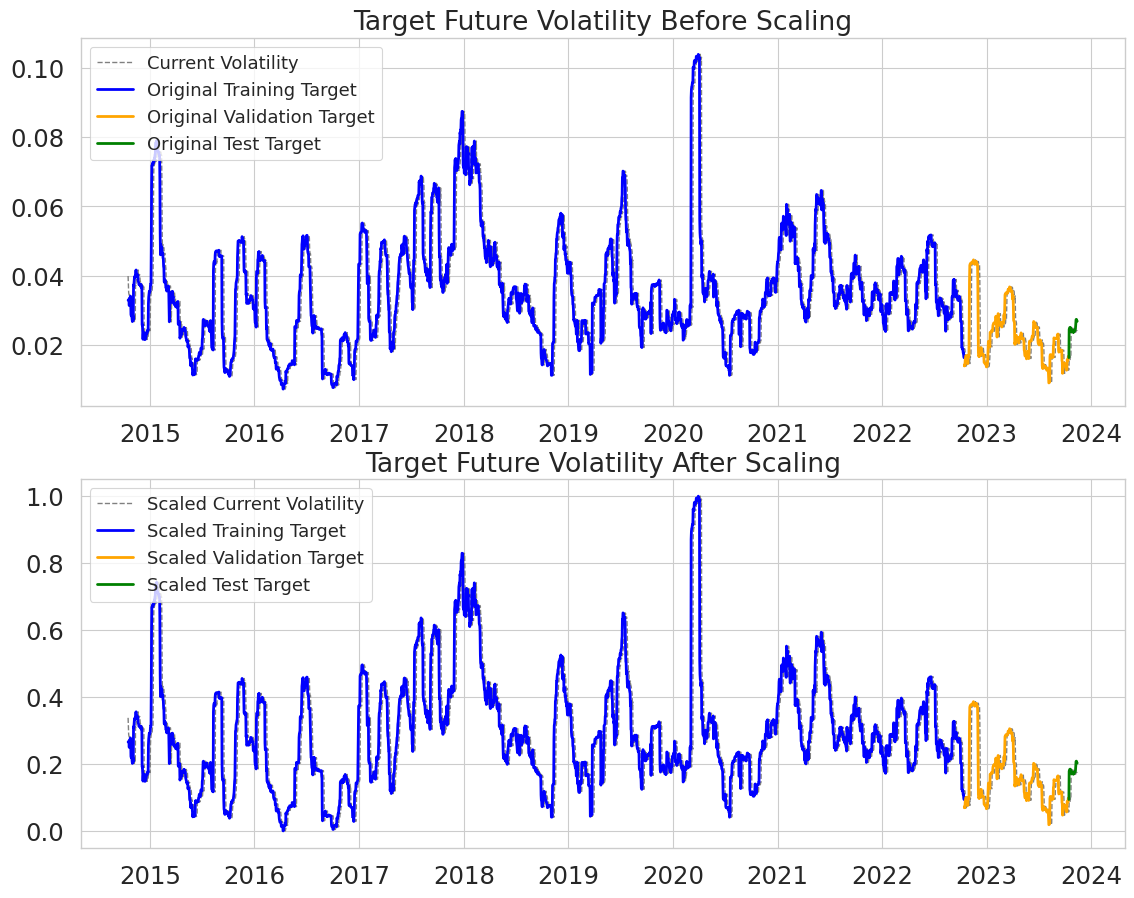

In [ ]:
sns.set_context("paper", font_scale=2)

with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current),
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show();

两张图之间最明显的区别之一是 y 轴。 缩放后波动率落在 [0,1] 范围内，而不是落在 [0, 0.12] 范围内。

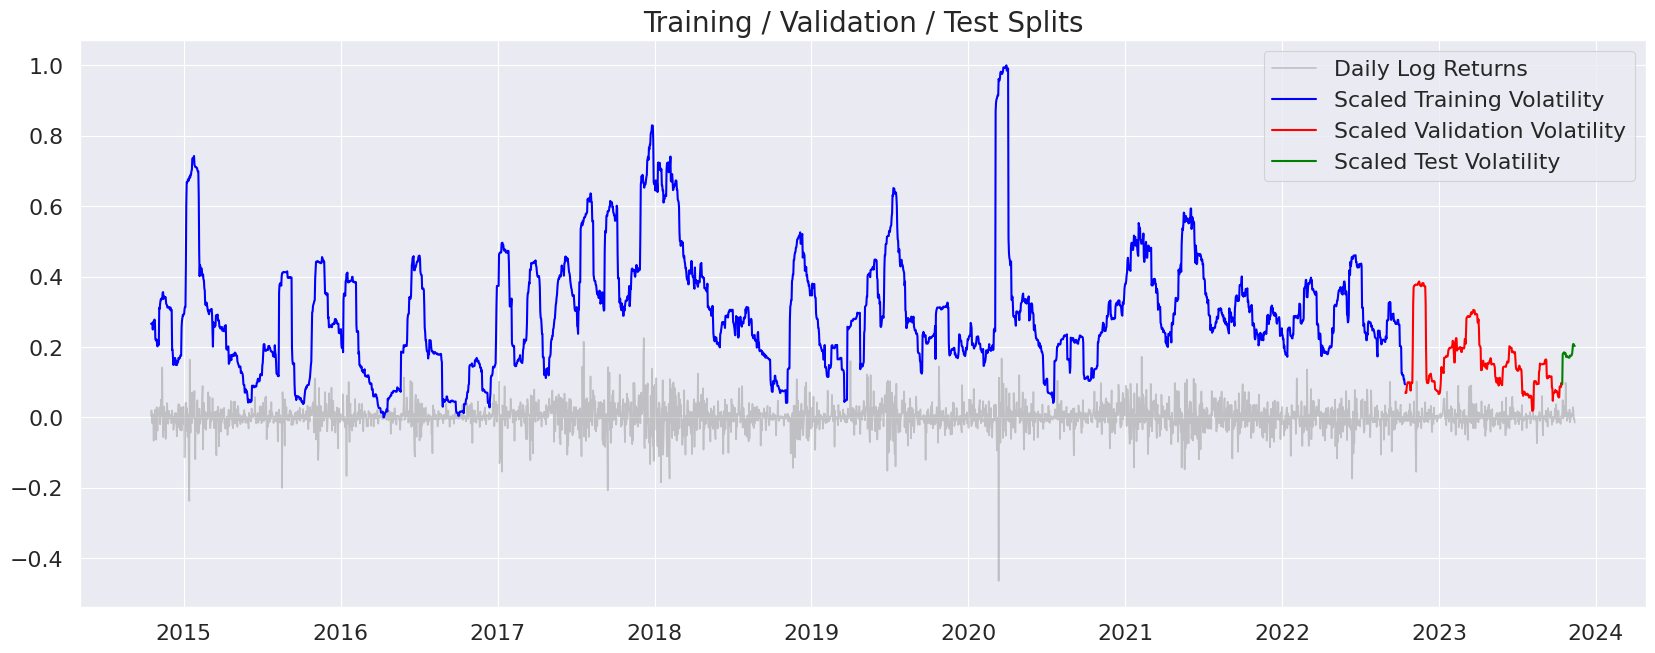

In [ ]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red',
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green',
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)

    plt.show();

# 建模

## 1. 评估指标

这里的两个主要指标是 **RMSPE（均方根百分比误差）** 和 **RMSE（均方根误差）**，其中 RMSPE 优先。 由于时间窗口选择的自由度，导致时间尺度在波动率的计算中非常重要。 因此 RMSPE 比其他指标更好地帮助捕获与期望目标值相比的误差，特别是当标签有很大的变化范围时，因为RMSPE在计算误差时考虑了百分比差异，可以更好地反映实际情况。


In [ ]:
def RMSPE(y_true, y_pred):

    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [ ]:
def RMSE(y_true, y_pred):

    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,RMSPE(y_true, y_pred),RMSE(y_true, y_pred)]
    return perf_df

In [ ]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

## 2. Bsaeline

### 2.1。 均值

波动性的基本特征之一是它在长期内的**均值回归**。 因此第一个baseline将是一个非常简单的模型，仅输出整个训练集已实现波动率的均值作为预测结果

In [ ]:
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2988545351733064

In [ ]:
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

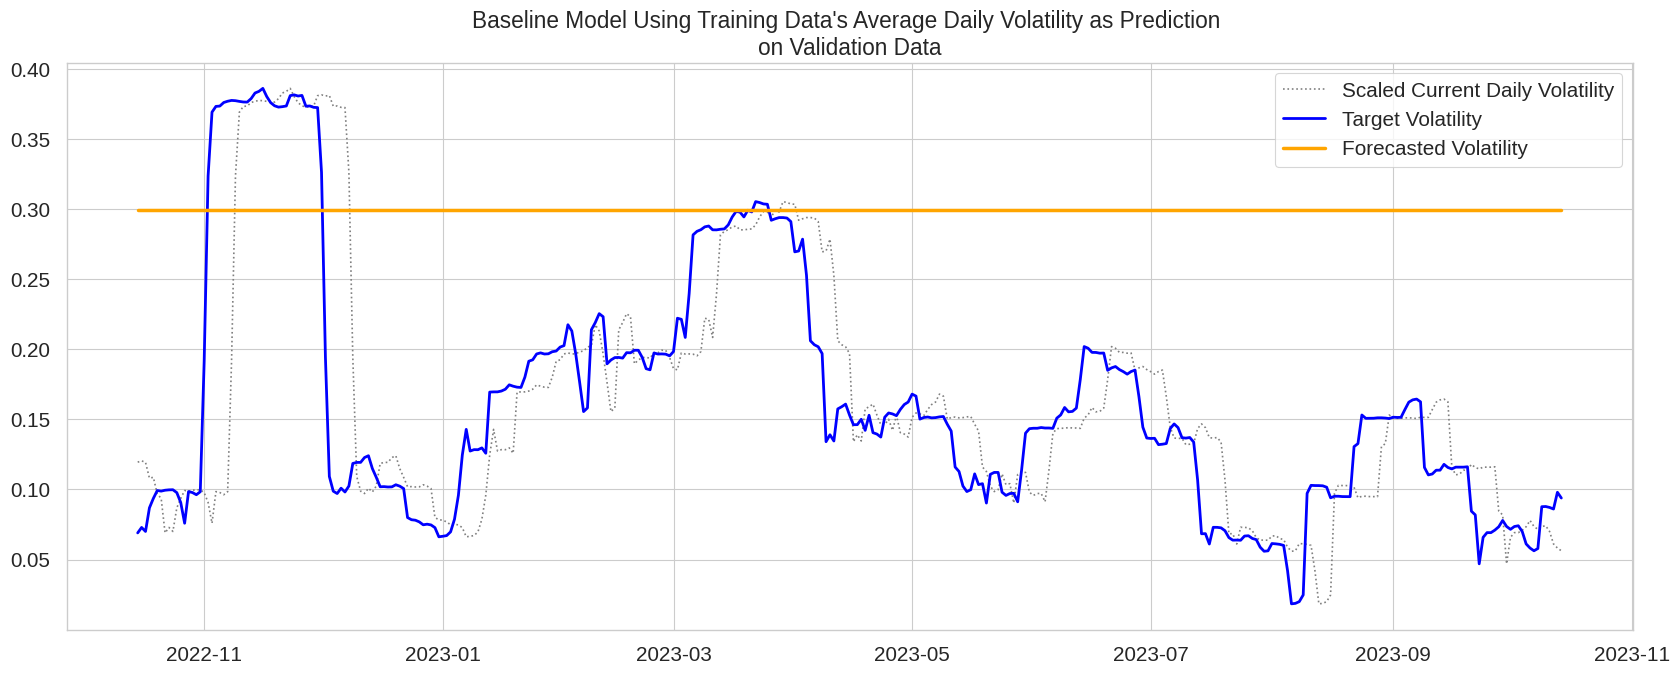

In [ ]:
viz_model(y_val_scaled, baseline_preds,
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.show();

In [ ]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          2.271653         0.160575

### 2.2。 Random Walk

波动性在短期内往往是**自相关**和**集群**的。 基于该性质建立一个简单的模型，该模型仅通过使用前一个时间戳的每日已实现波动率来“预测”未来的波动率。


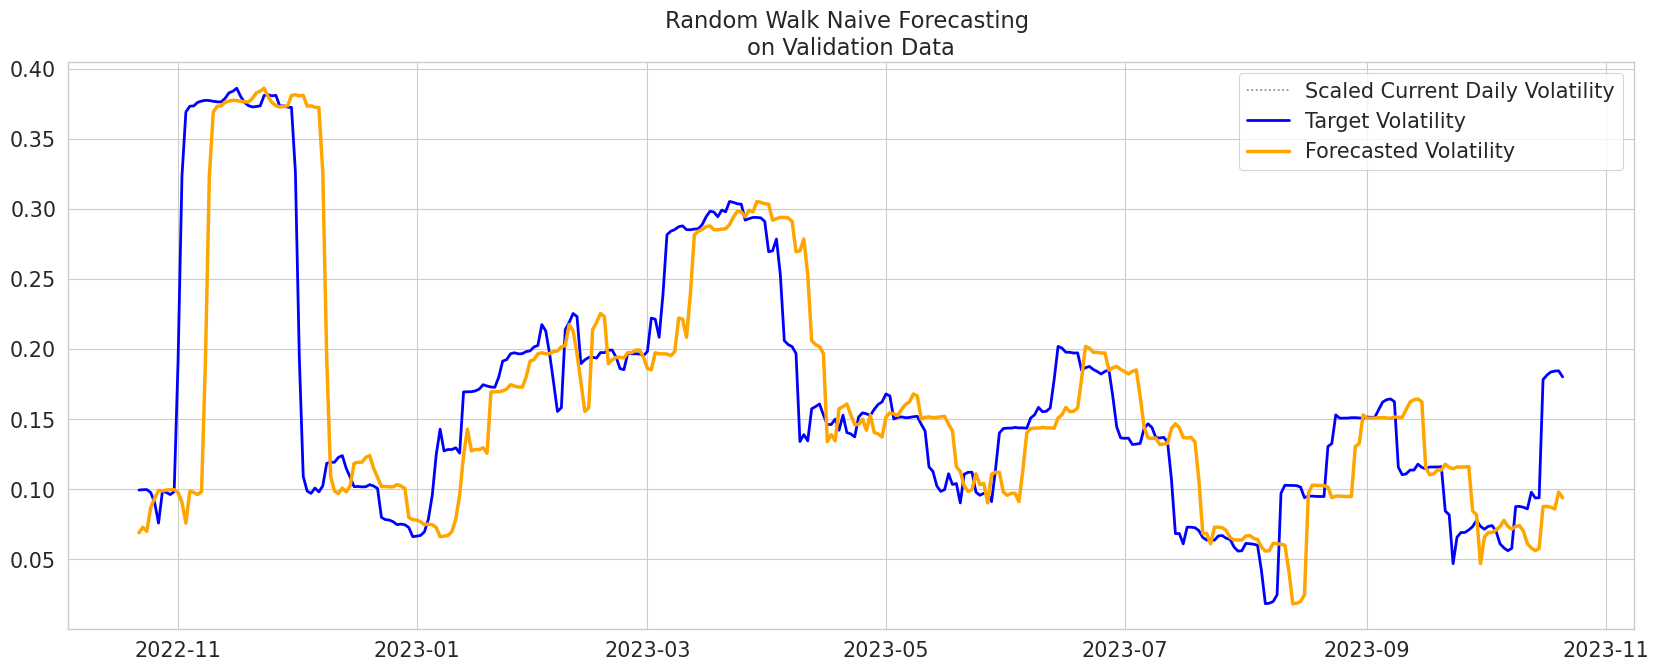

In [ ]:
random_walk_preds = x_val_scaled
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.show();

In [ ]:
log_perf(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          2.271653         0.160575
1  Random Walk Naive Forecasting          0.503847         0.062056

## 3.GARCH 模型


GARCH 代表**广义自回归条件异方差**，它是 ARCH 模型（自回归条件异方差）的扩展。

GARCH 包括滞后方差项和均值过程的滞后残差，是金融时间序列波动性预测的传统计量经济学方法。

在数学上，GARCH 可以表示如下：

\begin{align*}
\sigma_{t}^2 = \omega + \sum_{i}^{q}\alpha_{i}\epsilon_{t-i}^2 + \sum_{1}^{p}\beta_{i}\sigma_{t-i}^2
\end{align*}

其中$\sigma_{t}^2$是时间戳“t”的方差，$\epsilon_{t-i}^2$是时间戳“t-1”的模型残差

GARCH(1,1) 仅包含一阶滞后项，其数学方程为：

\begin{align*}
\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}
\end{align*}

其中$\alpha$、$\beta$ 和$\omega$ 之和为1，$\omega$ 是长期方差。



 GARCH 模型捕捉了波动性的基本特征：明天的波动性将接近今天的波动性（**聚类**），而长期的波动性可能**意味着回归**

### 3.1. 基础 GARCH

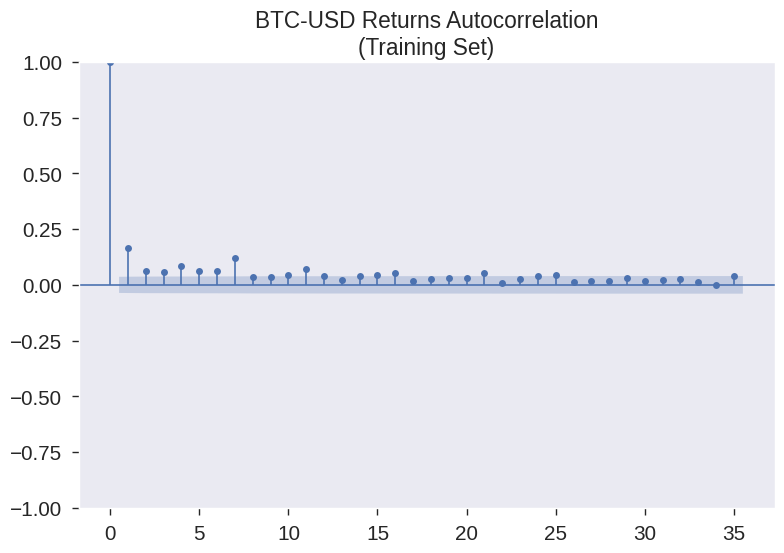

In [ ]:
plot_acf(r_train**2,
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

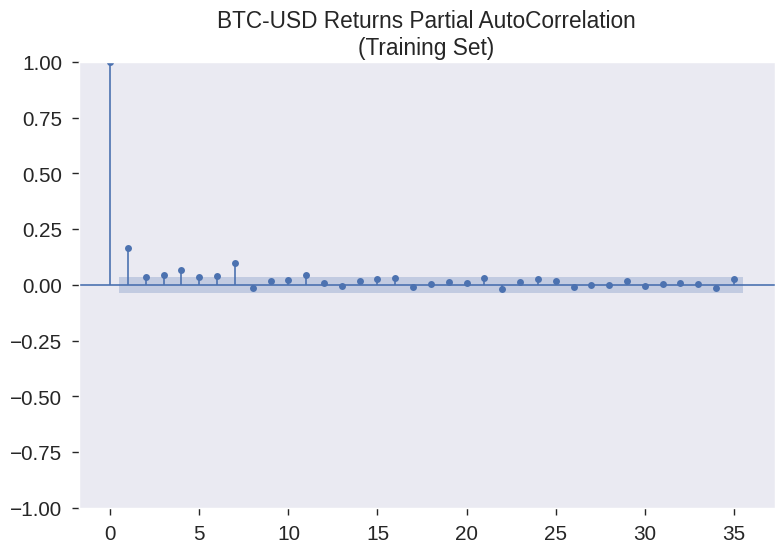

In [ ]:
plot_pacf(r_train**2,
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

自相关图表明，直到第 7 个滞后才存在显著相关性，而接下来的滞后似乎不太显著。



In [ ]:
from arch import arch_model

In [ ]:
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7934.68
Distribution:                  Normal   AIC:                           15901.4
Method:            Maximum Likelihood   BIC:                           15997.2
                                        No. Observations:                 2956
Date:                Sun, Nov 26 2023   Df Residuals:                     2955
Time:                        15:26:11   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1939  5.950e-02      3.259  1.119e-03 [7.728e-

基于 0.05 的显著性水平，所有系数似乎都不具有统计显著性。因此，把 `p` 和 `q` 的值减少到 1，看看是否有帮助。

In [ ]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7950.71
Distribution:                  Normal   AIC:                           15909.4
Method:            Maximum Likelihood   BIC:                           15933.4
                                        No. Observations:                 2956
Date:                Sun, Nov 26 2023   Df Residuals:                     2955
Time:                        15:26:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1969  5.850e-02      3.366  7.626e-04 [8.226e-

现在所有系数看起来都具有统计显显著性。

在将GARCH模型拟合到训练数据（百分比收益）后，GARCH模型的预测结果中包含了样本内时间序列的条件波动率的估计属性。对样本内的条件波动率进行（fit-transform）处理，并将其绘制出来，以便与上面计算得到的实际波动率（也进行了缩放的）x_train_scaled进行比较。

In [ ]:
def scale_tf_cond_vol(model_result):

    cond_vol = model_result.conditional_volatility
    scaler = MinMaxScaler()
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))
    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [ ]:
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [ ]:
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

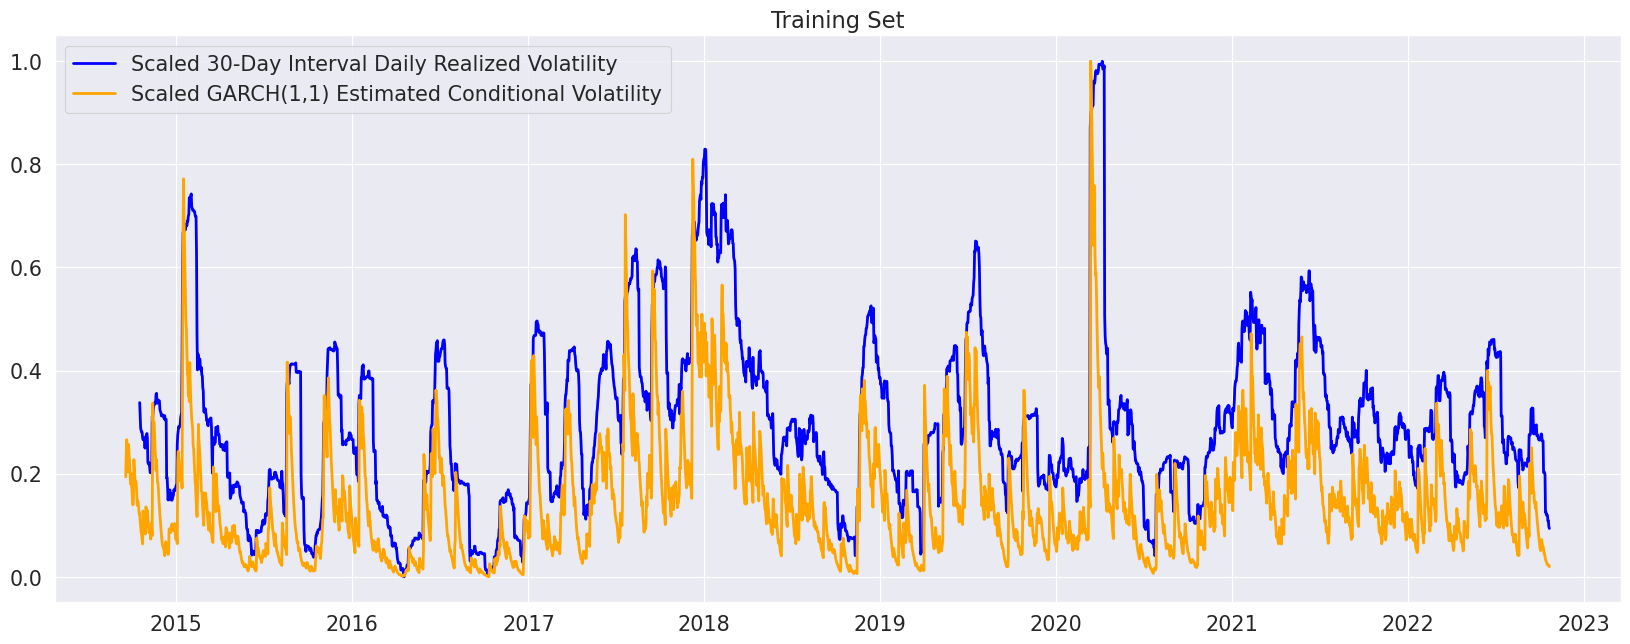

In [ ]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

#### 3.1.1。 预测

在这里使用滚动窗口的验证策略，即上一个时间戳的验证集在下一步时间戳的验证时添加到训练集中

In [ ]:
rolling_forecasts = []
idx = df.index

for i in range(len(val_idx)):

    idx = val_idx[i]
    train = df.returns[:idx]
    model = arch_model(train, vol='GARCH', p=1, q=1,dist='normal')
    model_fit = model.fit(disp='off')

    vaR = model_fit.forecast(horizon=n_future,reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [ ]:
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

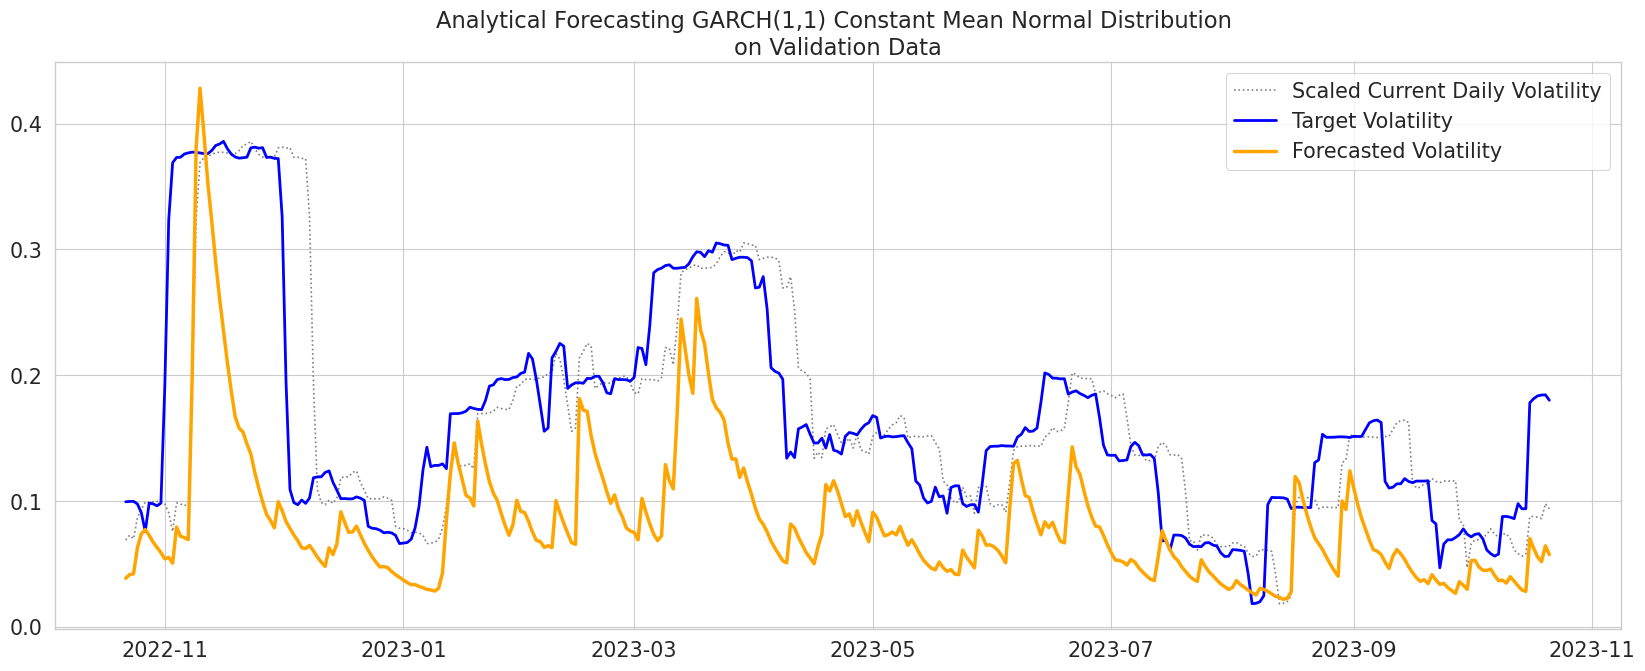

In [ ]:
viz_model(y_val_scaled, gm_1_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

与标签相比，GARCH对未来 7 天的预测仍然滞后。 与上面的样本内波动率比较类似，而且GARCH 预测出的波动率似乎较低（标准化后）。

In [ ]:
log_perf(y_val_scaled, gm_1_preds_scaled,
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          2.271653         0.160575
1           Random Walk Naive Forecasting          0.503847         0.062056
2  GARCH(1,1), Constant Mean, Normal Dist          0.517396         0.103361

感觉不如Random Walk...

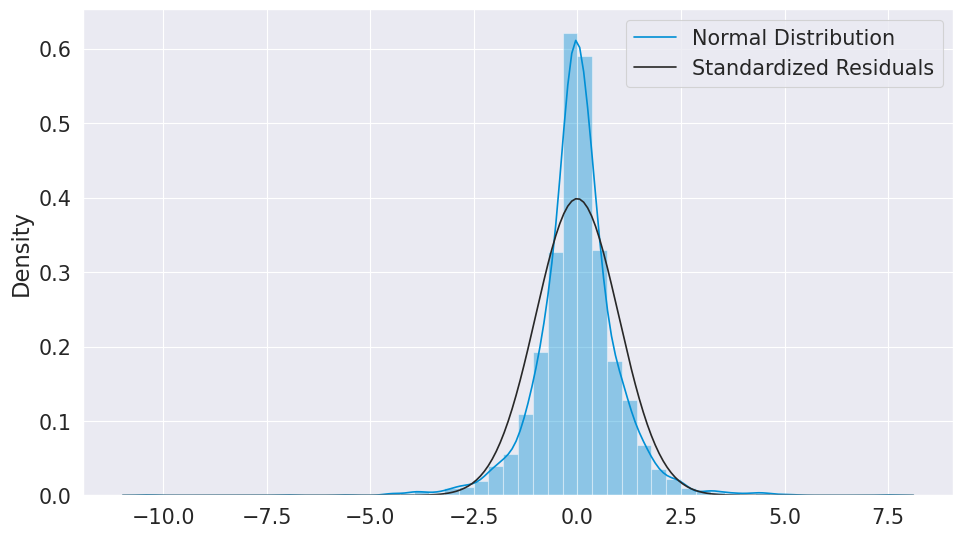

In [ ]:
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

gm_std_resid = gm_resid / gm_std

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

### 3.2。 具有不对称冲击响应的 GARCH 模型

基本的 GARCH 模型假设正向冲击和负向冲击对波动性的影响相似。 然而，现实中收益率与波动率通常是不对称的，负面影响往往比正面影响对波动性的影响更大，这也就是为什么股票市场分布右偏分布。

GARCH 的升级版可以解释冲击响应的不对称性，称为 **GJR-GARCH**（**Glosten-Jagannathan-Runkle GARCH** 的缩写）。

该模型通过将“o”设置为 1，这意味着模型将包含一个不对称冲击的滞后，该滞后将 GARCH 模型转换为具有方差动态的 GJR-GARCH 模型。

In [ ]:
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1,
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -7562.70
Distribution:      Standardized Skew Student's t   AIC:                           15139.4
Method:                       Maximum Likelihood   BIC:                           15181.3
                                                   No. Observations:                 2956
Date:                           Sun, Nov 26 2023   Df Residuals:                     2955
Time:                                   15:27:39   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [ ]:
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

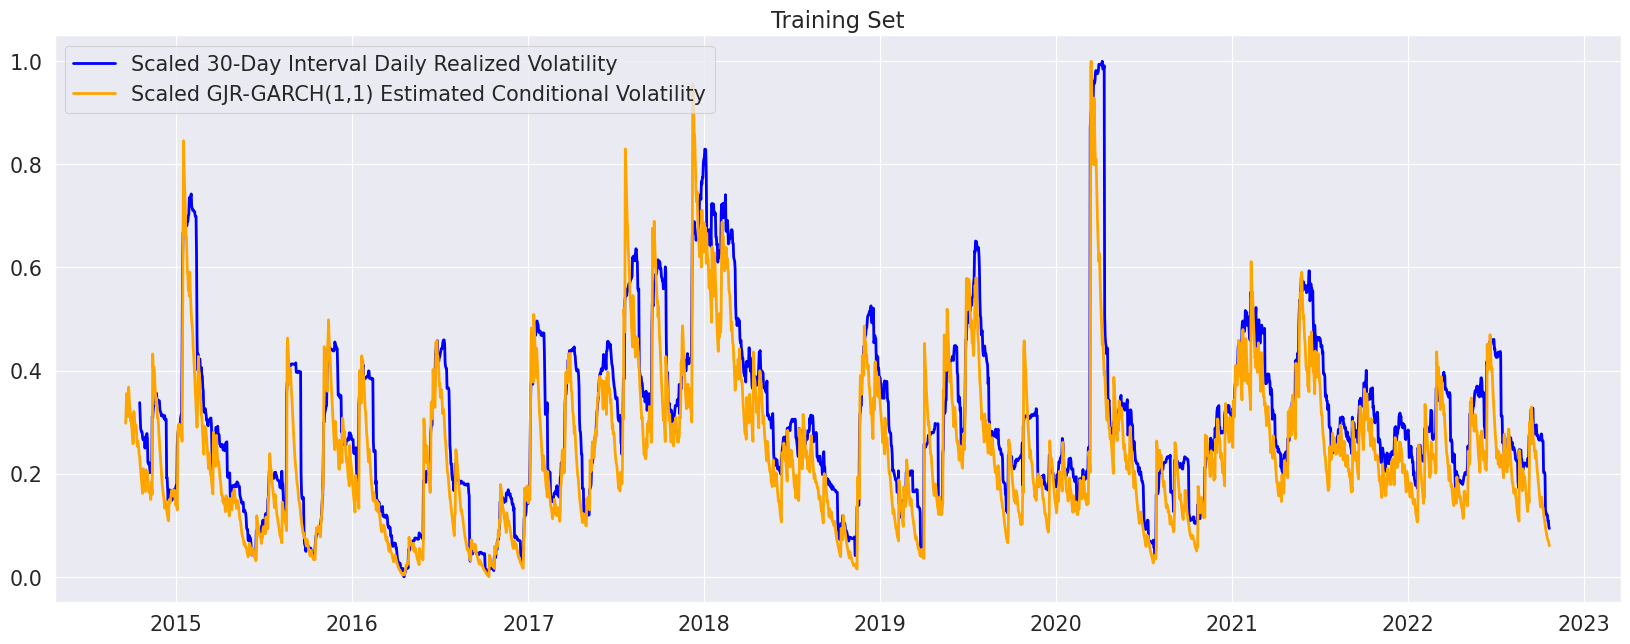

In [ ]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [ ]:
rolling_forecasts = []

for i in range(len(val_idx)):
    idx = val_idx[i]
    train = df.returns[:idx].dropna()
    model = arch_model(train, p=1, q=1, o=1,vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    vaR = model_fit.forecast(horizon=n_future,reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

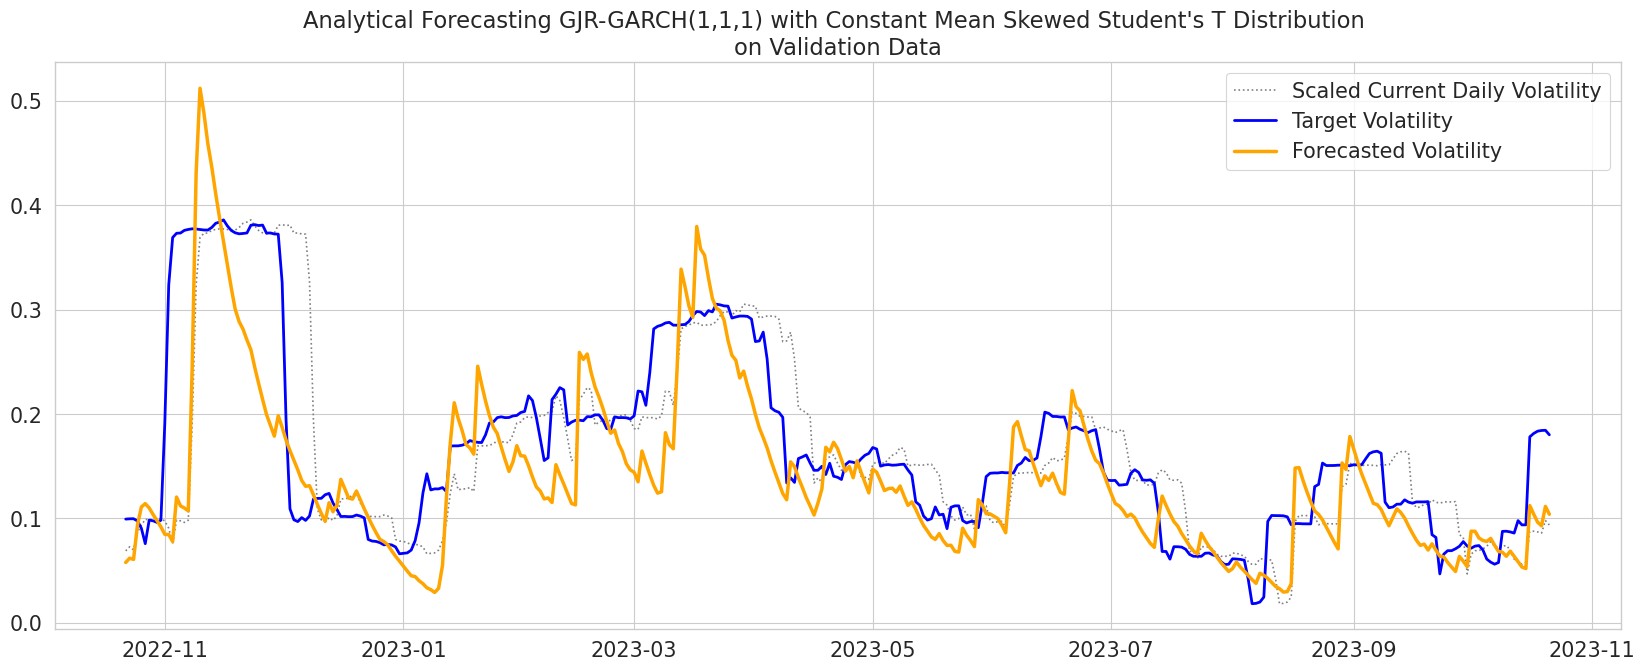

In [ ]:
viz_model(y_val_scaled, gjr_1_preds_scaled,
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [ ]:
log_perf(y_val_scaled, gjr_1_preds_scaled,
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.271653   
1                           Random Walk Naive Forecasting          0.503847   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517396   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.327460   

   Validation RMSE  
0         0.160575  
1         0.062056  
2         0.103361  
3         0.062464

GJR-GARCH(1,1,1)的RMSPE相比之前的模型有了飞跃，但RMSE与Random Walk相似，这暗示我们GJR-GARCH(1,1,1)更好的捕捉到了冲击事件的影响

### 3.3. TARCH



GARCH 家族中还有一个成员称为 **TARCH**，它是 **阈值自回归条件异方差** 的缩写（也称为 **ZARCH**）。 TARCH 使用绝对值（而不是平方）对波动率进行建模。 该模型使用“power=1.0”指定，此外，GARCH框架还通过使用虚拟变量将非对称影响纳入其中

TARCH(1,1) 模型中的波动过程由下式给出：

\begin{align*}
\sigma_{t} = \omega + \alpha|\epsilon_{t-1}| + \gamma|\epsilon_{t-1}|I_{[\epsilon_{t-1}<0]} + \beta\sigma_{t-1}
\end{align*}

In [ ]:
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7560.88
Distribution:      Standardized Skew Student's t   AIC:                           15135.8
Method:                       Maximum Likelihood   BIC:                           15177.7
                                                   No. Observations:                 2956
Date:                           Sun, Nov 26 2023   Df Residuals:                     2955
Time:                                   15:28:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-Likelihood 和 AIC/BIC 与 GJR-GARCH 模型非常相似

In [ ]:
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

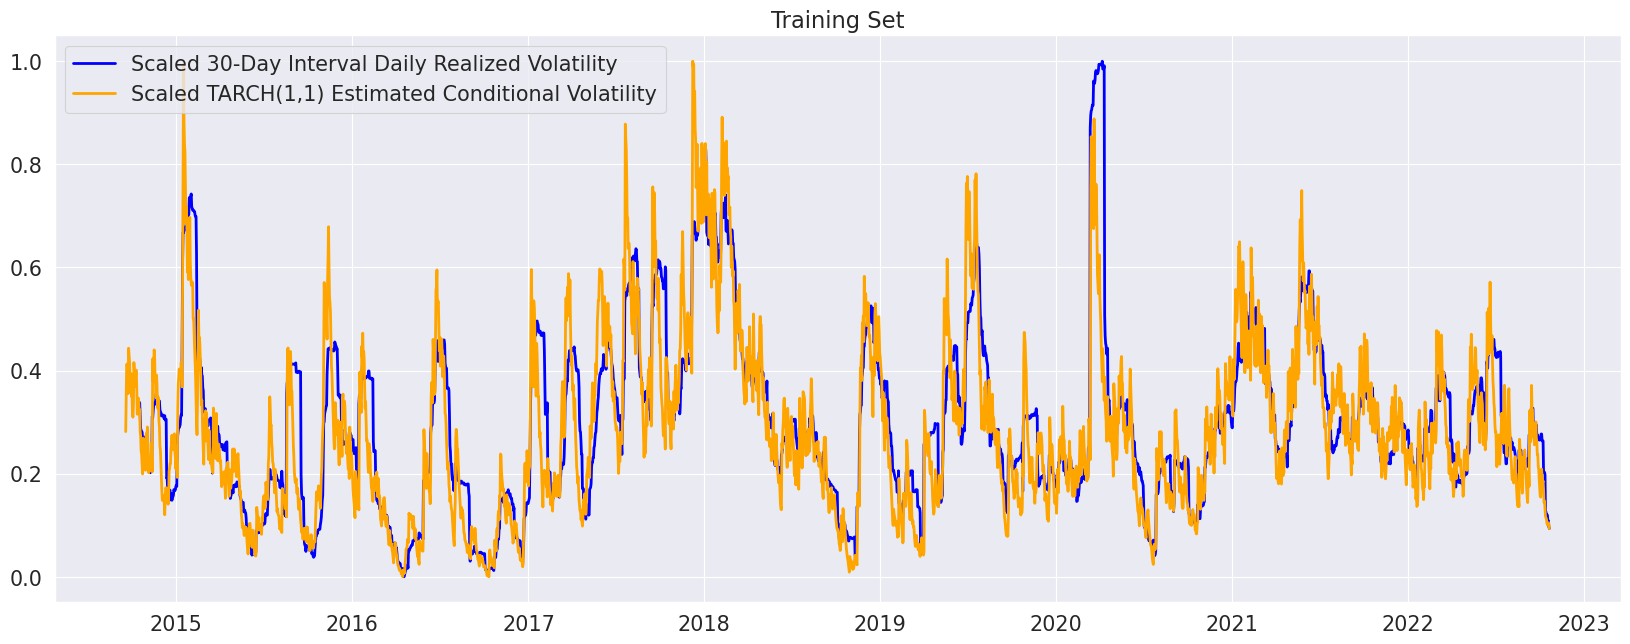

In [ ]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

In [ ]:
rolling_forecasts = []

for i in range(len(val_idx)):
    idx = val_idx[i]
    train = df.returns[:idx].dropna()
    model = arch_model(train, p=1, o=1, q=1, power=1.0,dist='skewt')
    model_fit = model.fit(disp='off')
    vaR = model_fit.forecast(horizon=n_future,reindex=False,method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

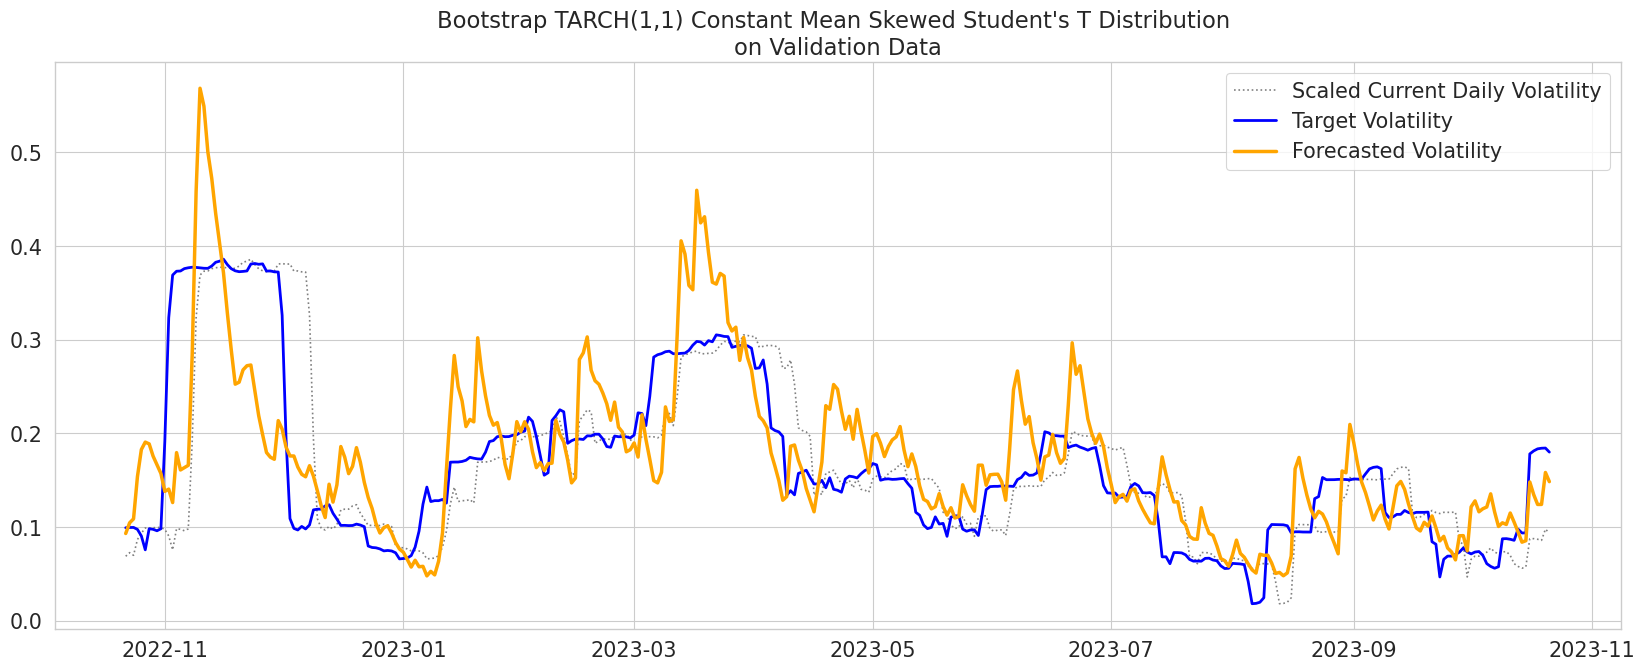

In [ ]:
viz_model(y_val_scaled, t_bs_preds_scaled,
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

The forecasted volatility does seem to catch up with the target better than all other models did. This is promising...

In [ ]:
log_perf(y_val_scaled, t_bs_preds_scaled,
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.271653   
1                           Random Walk Naive Forecasting          0.503847   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517396   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.327460   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.453947   

   Validation RMSE  
0         0.160575  
1         0.062056  
2         0.103361  
3         0.062464  
4         0.064456

#### 3.3.3。 TARCH 的超参数调整

接下来，我将为 p、q 和 o 创建从 0 到 3（包含）的一系列值，然后使用 RMSPE 记录每个模型在验证集上的性能。

In [ ]:
import itertools

In [ ]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
rmspe_s = []
LLH_s = []
bic_s = []

for p, q, o in pqo_s:
    np.random.seed(seed)
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)
    sclr = sclr.fit(cond_vol_arr)

    rolling_forecasts = []

    for i in range(len(r_val)):
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        vaR = model_fit.forecast(horizon=n_future,
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        rolling_forecasts.append(pred)

    y_preds = pd.Series(rolling_forecasts, index=val_idx)
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

In [ ]:
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.40343847275610123 using TARCH(2, 1, 2)


In [ ]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

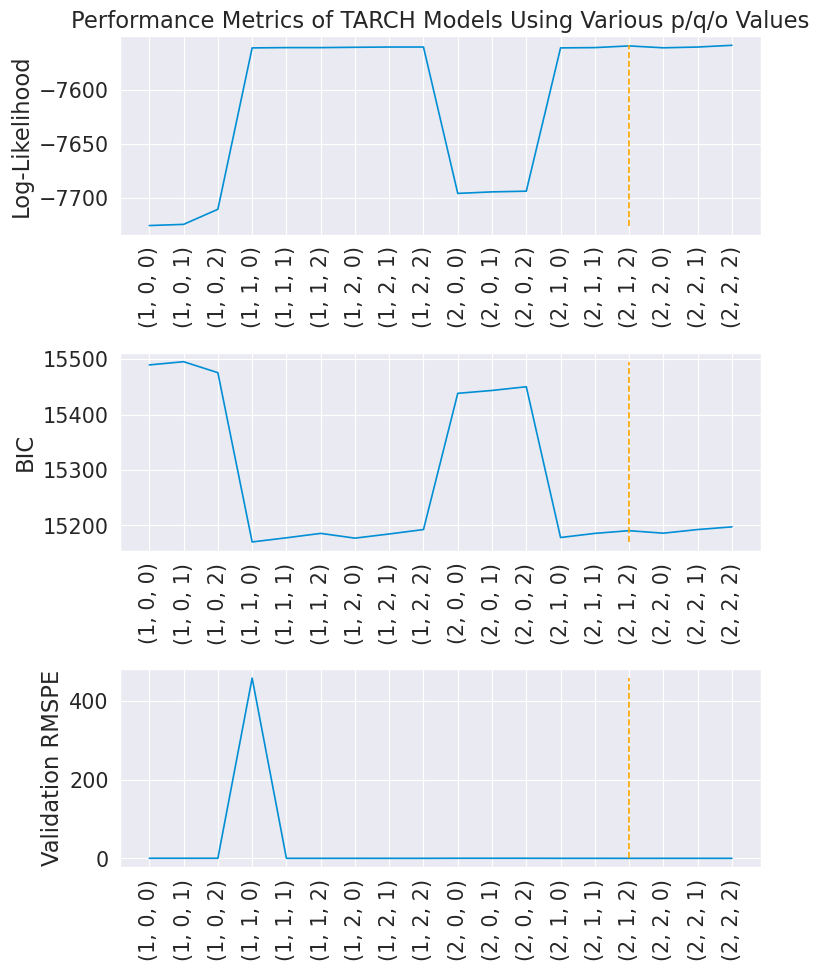

In [ ]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo),
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo),
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo),
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();

### 3.4. 最终的 GARCH 模型 - TARCH(1,2)



In [ ]:
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7559.32
Distribution:      Standardized Skew Student's t   AIC:                           15136.6
Method:                       Maximum Likelihood   BIC:                           15190.6
                                                   No. Observations:                 2956
Date:                           Sun, Nov 26 2023   Df Residuals:                     2955
Time:                                   16:02:06   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

In [ ]:
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

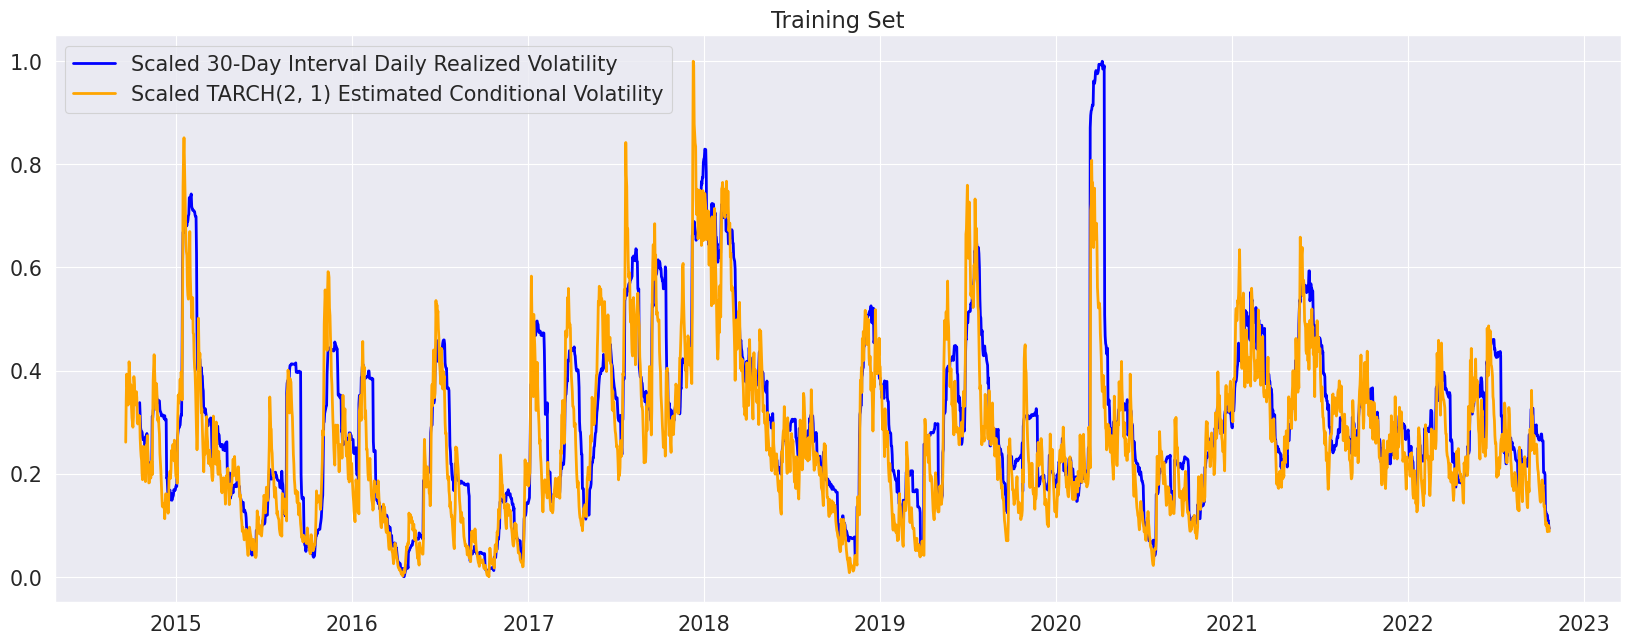

In [ ]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [ ]:
rolling_forecasts = []

for i in range(len(val_idx)):

    idx = val_idx[i]
    train = df.returns[:idx].dropna()
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')
    vaR = model_fit.forecast(horizon=n_future,reindex=False,method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

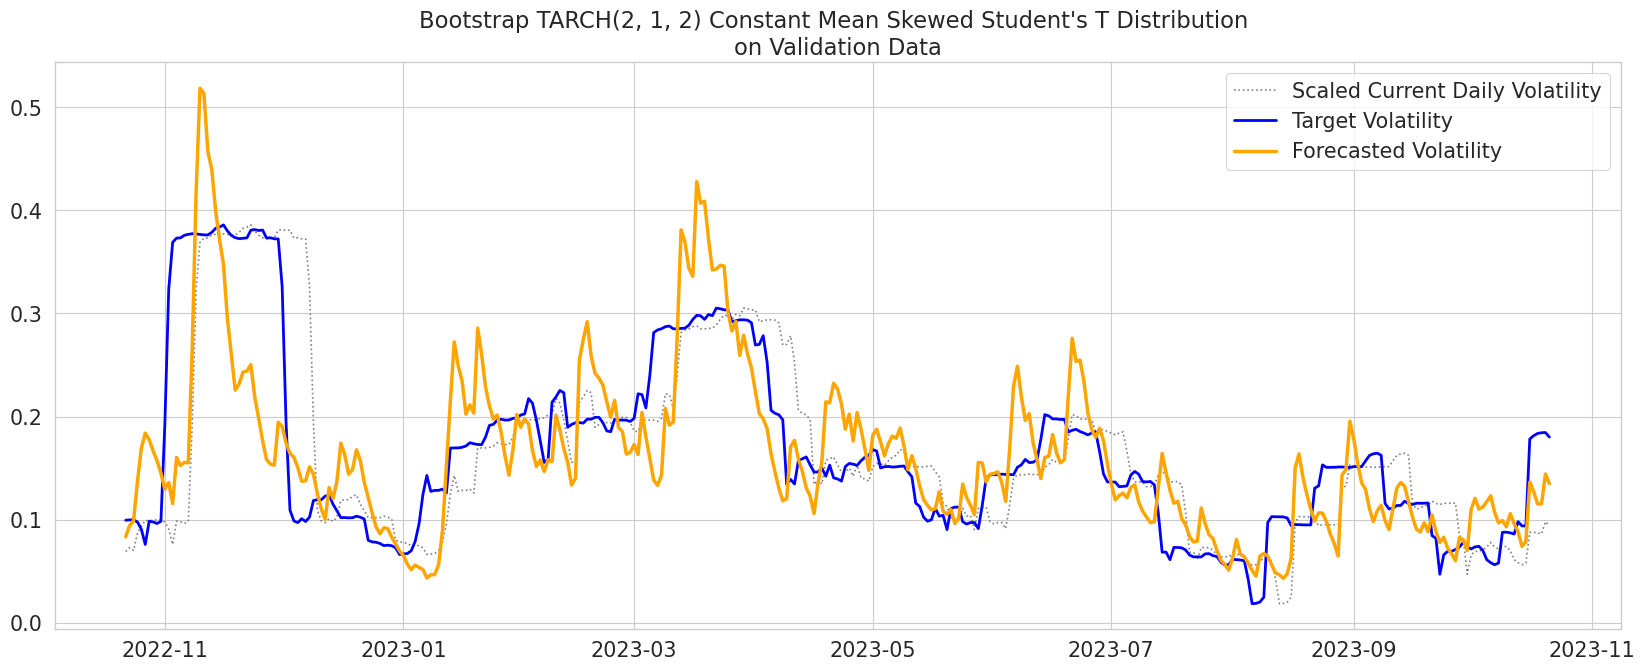

In [ ]:
viz_model(y_val_scaled, t_120_preds_scaled,
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")

plt.show();

In [ ]:
log_perf(y_val_scaled, t_120_preds_scaled,
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.271653   
1                           Random Walk Naive Forecasting          0.503847   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517396   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.327460   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.453947   
5     Bootstrap TARCH(2, 1, 2), Constant Mean, Skewt Dist          0.405107   

   Validation RMSE  
0         0.160575  
1         0.062056  
2         0.103361  
3         0.062464  
4         0.064456  
5         0.063683

### 4. 神经网络


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

对于神经网络，我将使用**滑动窗口**来建立训练集和验证集，而不是将所有可用数据点输入网络。

In [ ]:
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [ ]:
def rmspe(y_true, y_pred):

    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [ ]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [ ]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [ ]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

### 4.2. 单变量长短期记忆 (LSTM)**



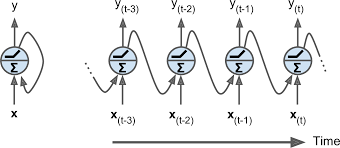

在每个时间戳“t”，循环神经元接收输入 $x_{t}$ 以及它自己的前一个时间戳 $y_{t-1}$ 的输出。 由于循环神经元的输出是之前时间步骤的所有输入的函数，因此它具有*记忆*的形式，并且能够随着时间的推移保留一些信息。

然而，由于数据在遍历 RNN 时会经历一些转换，因此每个时间戳都会丢失一些信息，并且对于长序列，RNN 的状态实际上不包含来自第一个输入的信息。

**长短期记忆 (LSTM)** 由 Sepp Hochreiter 和 Jurgen Schmidhuber 于 1997 年提出。 LSTM 的关键部分是网络可以学习什么是重要的、需要长期保存的，什么是可以忽略的。 LSTM 看起来与常规 RNN 单元非常相似，但它的状态分为 2 个向量：
- $h_{t}$ - 用于短期状态
- $c_{t}$ - 用于长期状态

LSTM 是一个黑匣子，可以像基本的循环神经网络 (RNN) 单元一样使用。 然而，它往往表现得更好，有助于训练更快地收敛，并且还可以检测数据中的长期依赖性。



第一个 LSTM 模型非常简单，只有 1 个包含 20 个单元的隐藏 LSTM 层。 我在这里使用标准的“adam”优化器，如果需要的话稍后会尝试其他优化器。

In [ ]:

tf.keras.backend.clear_session()

np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.LSTM(20),

    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

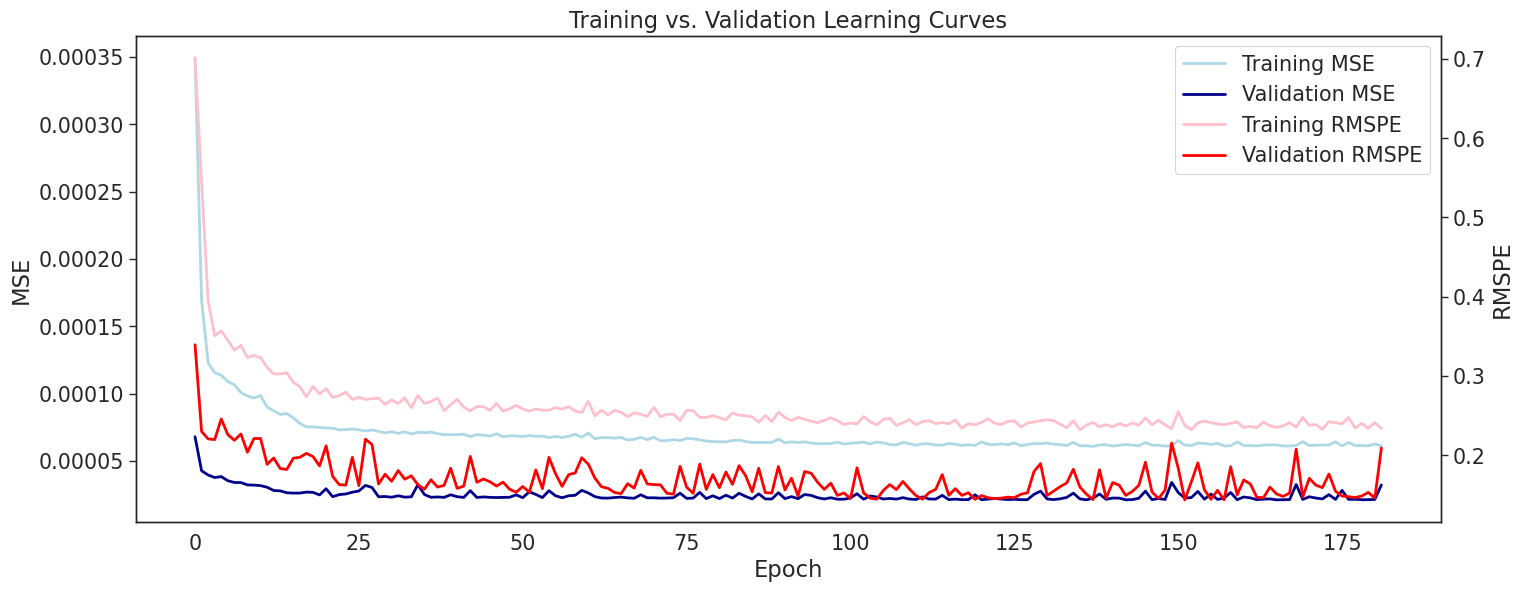

In [ ]:
viz_train_val_metrics(lstm_1_res)

验证 RMSPE 实际上低于训练 RMSPE，但总体而言，除训练集 MSE 之外的所有的线看起来都相当不稳定。

In [ ]:
lstm_1_preds = forecast(lstm_1, val_idx)
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 1s 5ms/step


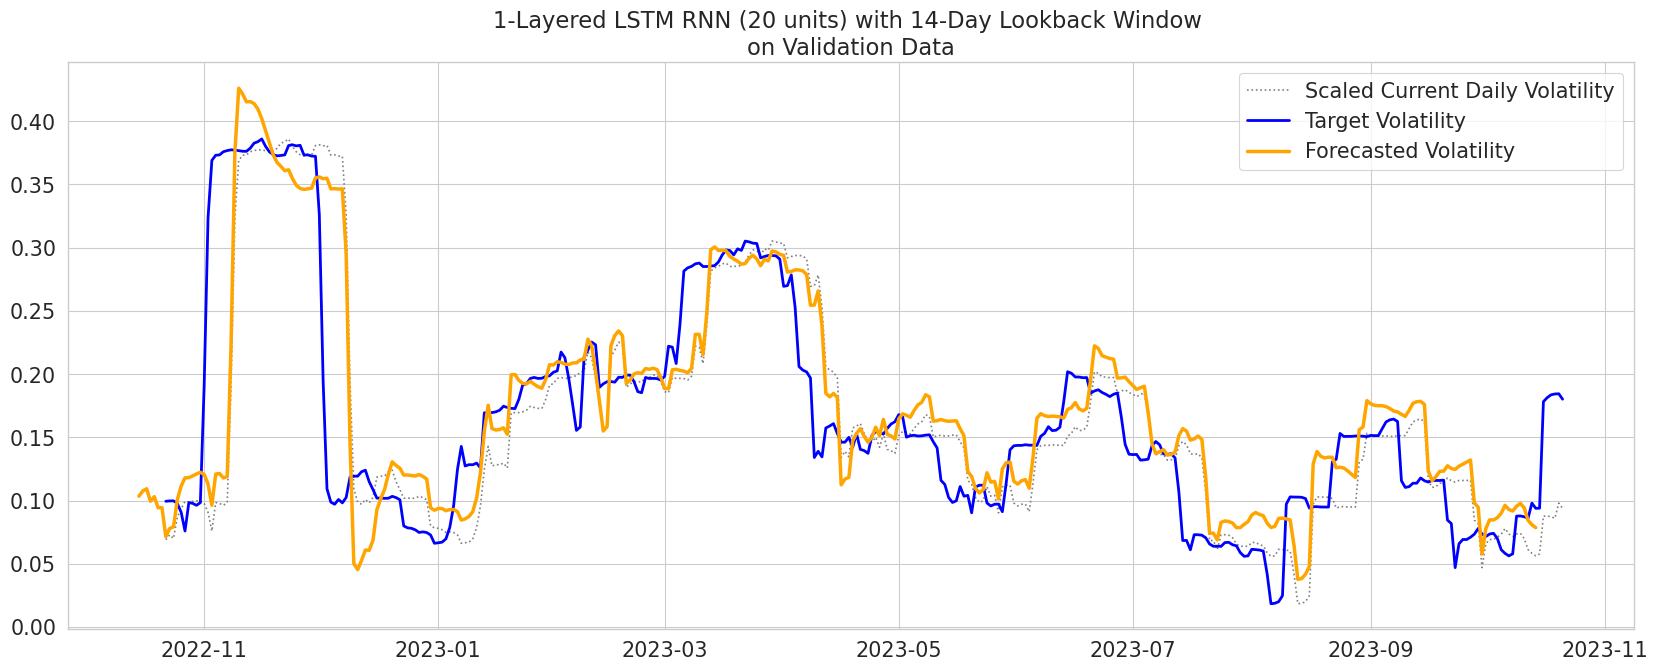

In [ ]:
viz_model(y_val_scaled, lstm_1_preds_scaled,
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

plt.show();

Again, predictions traces `vol_current` quite closely, and the prediction line has smoothed out compared to the fully connected NN's predictions (meaning it's less noisy), but it is still also lagging behind compared to desired target.

In [ ]:
log_perf(y_val_scaled, lstm_1_preds_scaled,
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.271653   
1                           Random Walk Naive Forecasting          0.503847   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517396   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.327460   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.453947   
5     Bootstrap TARCH(2, 1, 2), Constant Mean, Skewt Dist          0.405107   
6                        LSTM 1 layer 20 units, n_past=14          0.568074   

   Validation RMSE  
0         0.160575  
1         0.062056  
2         0.103361  
3         0.062464  
4         0.064456  
5         0.063683  
6         0.082555

效果目前是所有模型最差的

### 4.3. 单变量双向 LSTM


LSTM 单元有一个扩展，称为 **双向 LSTM**，在这种情况下，通过为模型提供额外的上下文，它可能会表现的更好。 由于输入序列的所有时间戳均已可用，因此双向 LSTM 可以在同一输入序列上训练 2 个而不是 1 个 单元。这有助于为网络提供额外的背景信息，并且通常可以更快、更全面地了解问题。

LSTM 允许跨时间维护某些长期记忆，因此我将 `n_past` 延长到 1 个月，并且还增加隐藏层的数量，看看模型是否可以更好地捕获某些模式。

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19105 (74.63 KB)
Trainable params: 19105 (74.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

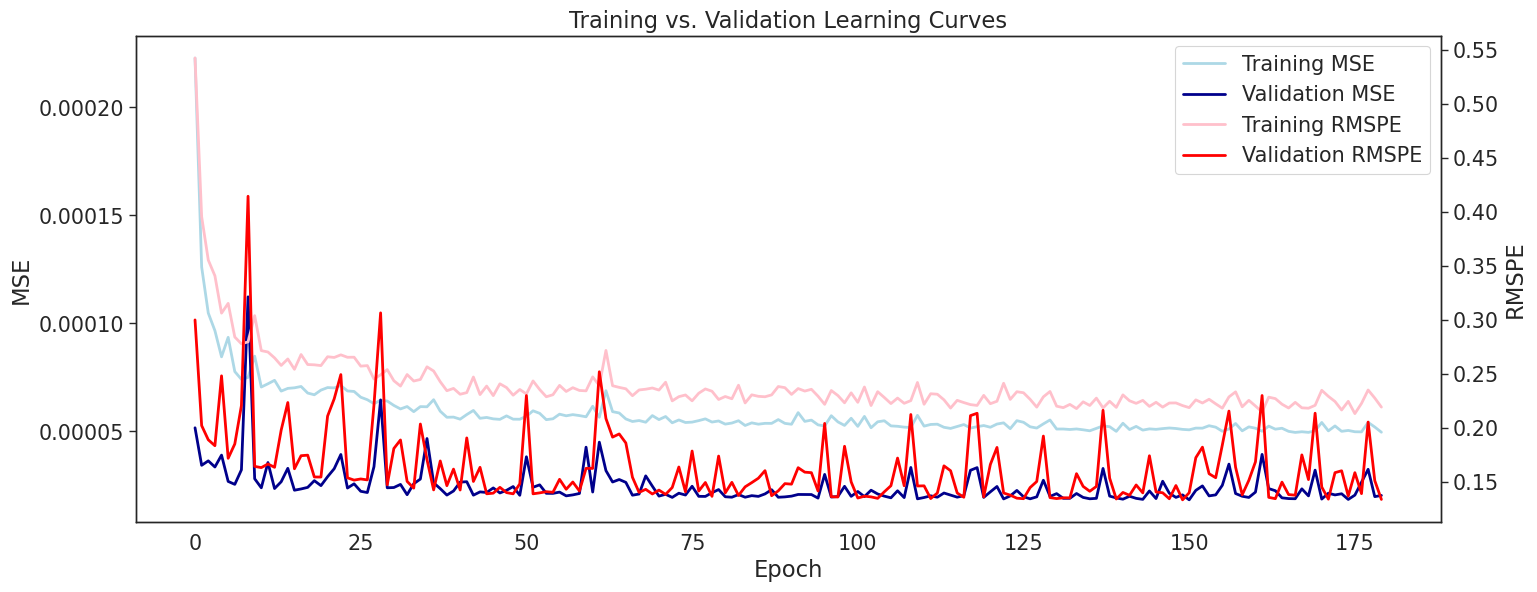

In [ ]:
viz_train_val_metrics(lstm_2_res)

In [ ]:
lstm_2_preds = forecast(lstm_2, val_idx)
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 2s 9ms/step


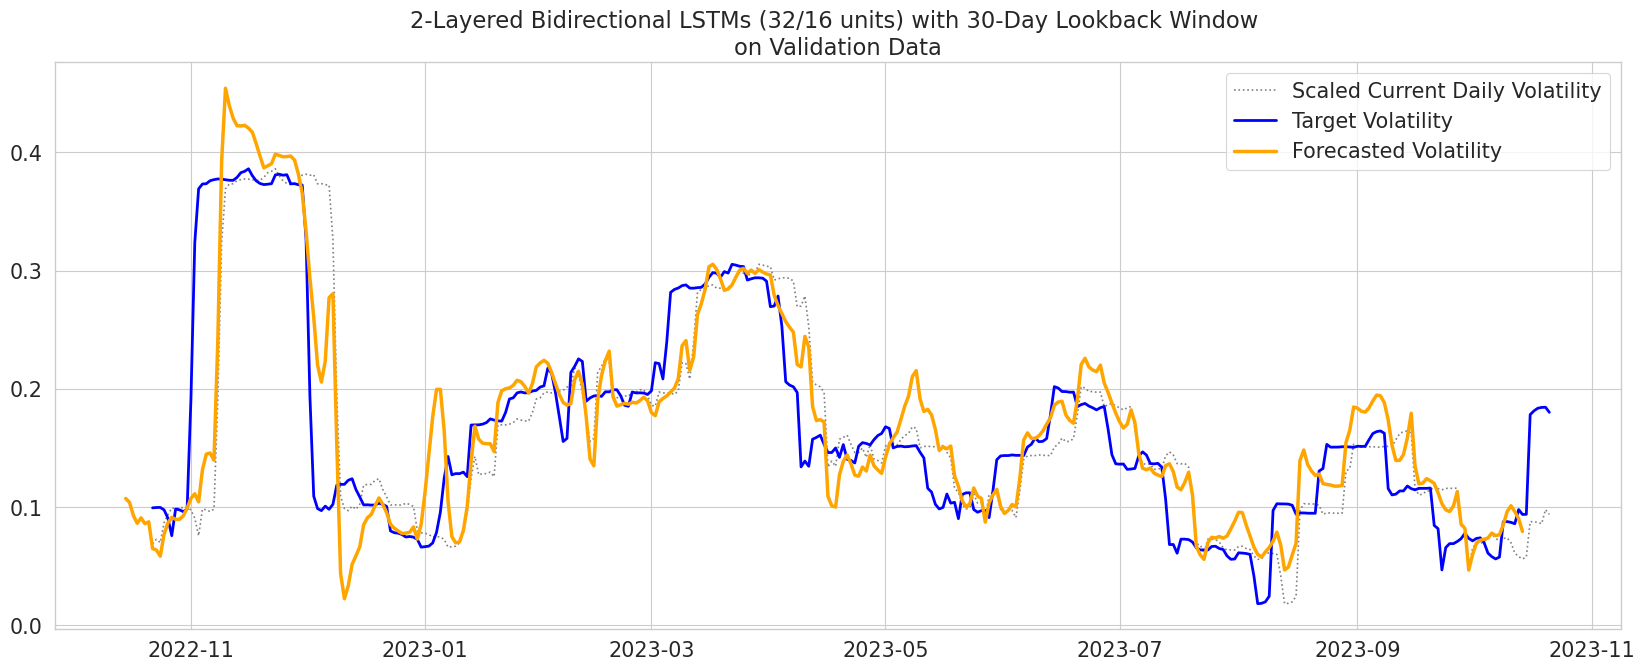

In [ ]:
viz_model(y_val_scaled, lstm_2_preds_scaled,
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
plt.show();

In [ ]:
log_perf(y_val_scaled, lstm_2_preds_scaled,
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.271653   
1                           Random Walk Naive Forecasting          0.503847   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.517396   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.327460   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.453947   
5     Bootstrap TARCH(2, 1, 2), Constant Mean, Skewt Dist          0.405107   
6                        LSTM 1 layer 20 units, n_past=14          0.568074   
7         2 layers Bidirect LSTM (32/16 units), n_past=30          0.426800   

   Validation RMSE  
0         0.160575  
1         0.062056  
2         0.103361  
3         0.062464  
4         0.064456  
5         0.063683  
6         0.082555  
7         0.081528

### 4.4. 单变量双向 LSTM + 一维卷积层


一维卷积层在序列上滑动多个内核，为每个内核生成一个一维特征图。 每个内核将学习检测单个非常短的顺序模式（不长于内核大小）。卷积层应该允许窗口扩展，并帮助模型进一步学习过去的模式。

In [ ]:
tf.keras.backend.clear_session()

np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),

    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           strides=2, padding="valid",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirection  (None, None, 64)          16640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27201 (106.25 KB)
Trainable params: 27201 

In [ ]:
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

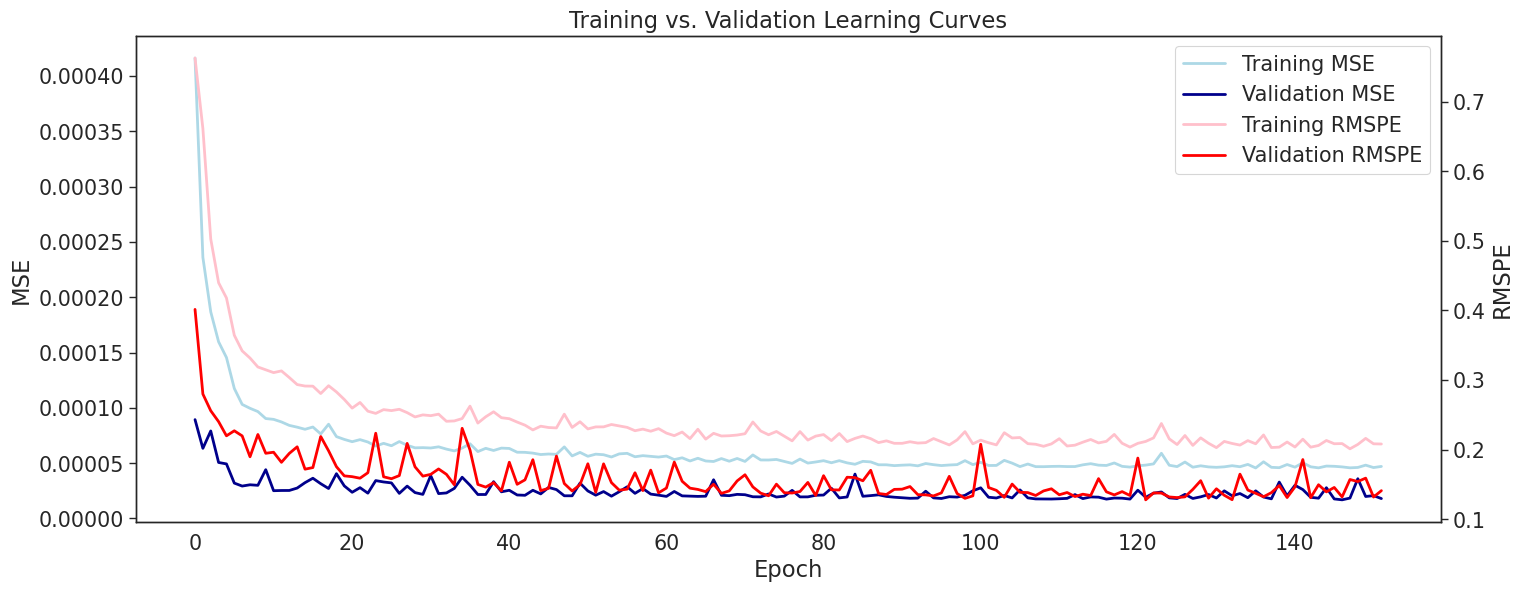

In [ ]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)

In [ ]:
lstm_3_preds = forecast(lstm_3, val_idx)
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 1s 6ms/step


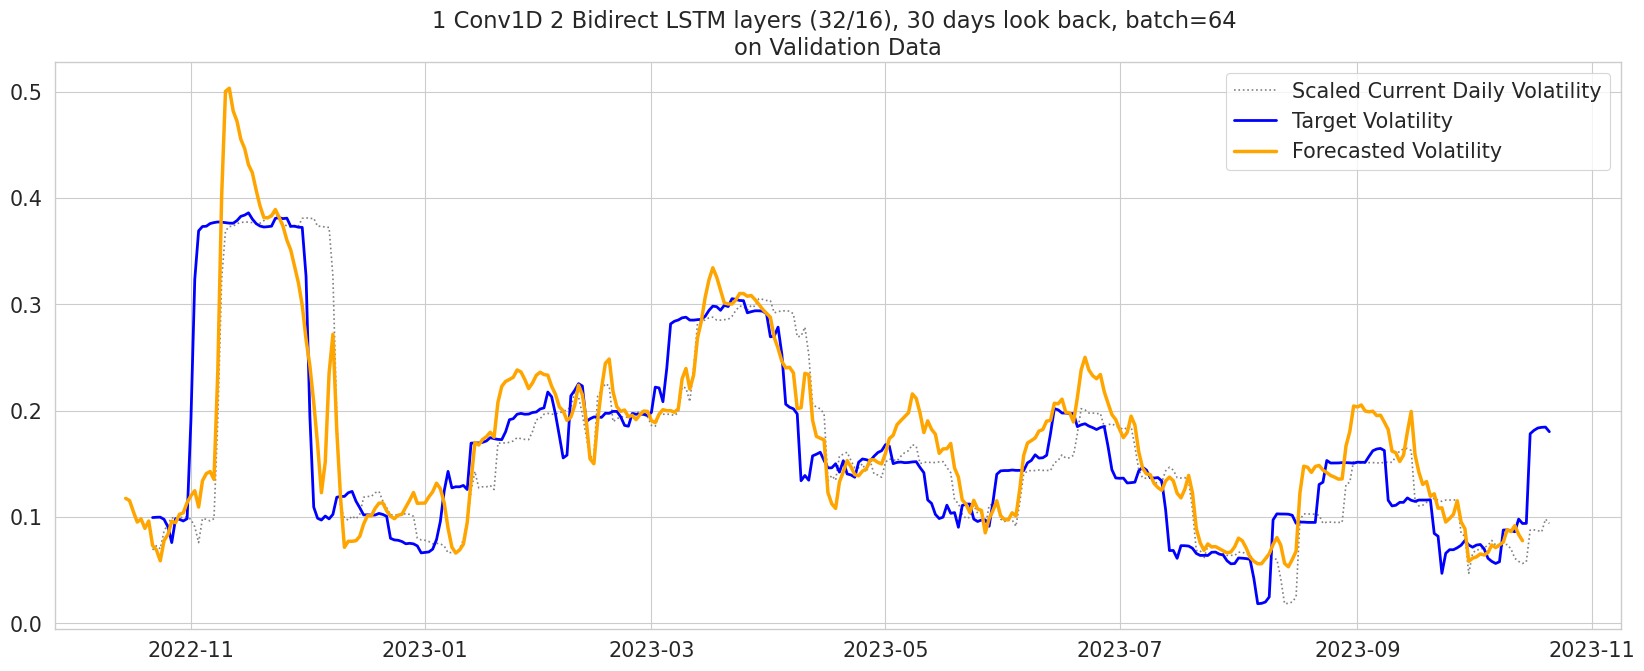

In [ ]:
viz_model(y_val_scaled, lstm_3_preds_scaled,
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
plt.show();

In [ ]:
log_perf(y_val_scaled, lstm_3_preds_scaled,
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

Model  \
0                                                 Mean Baseline   
1                                 Random Walk Naive Forecasting   
2                        GARCH(1,1), Constant Mean, Normal Dist   
3        Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4               Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5           Bootstrap TARCH(2, 1, 2), Constant Mean, Skewt Dist   
6                              LSTM 1 layer 20 units, n_past=14   
7               2 layers Bidirect LSTM (32/16 units), n_past=30   
8  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0          2.271653         0.160575  
1          0.503847         0.062056  
2          0.517396         0.103361  
3          0.327460         0.062464  
4          0.453947         0.064456  
5          0.405107         0.063683  
6          0.568074         0.082555  
7          0.426800         0.081528  
8          0.393906         0.078348

### 4.6。 多变量LSTM

到目前为止所有LSTM模型仅使用简单的一维输入，而对于金融数据这可能是不够的。 这可能就是为什么上述大多数模型似乎未能产生比GARCh预测更好的结果的原因。 无论使用多少个神经元或隐藏层，或者模型的架构有多复杂，数据不足很可能不会产生好的结果。
。

In [ ]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                             Volume   returns  log_returns  vol_current  \
Date                                                                      
2014-10-17 00:00:00+00:00  13600700  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  11416800  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00   5914570 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16419000 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  14188900  0.948166     0.009437     0.034362   

                           vol_future  
Date                                   
2014-10-17 00:00:00+00:00    0.032900  
2014-10-18 00:00:00+00:00    0.033009  
2014-10-19 00:00:00+00:00    0.033083  
2014-10-20 00:00:00+00:00    0.033017  
2014-10-21 00:00:00+00:00    0.031334

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3315 entries, 2014-10-17 00:00:00+00:00 to 2023-11-13 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3315 non-null   float64
 1   High         3315 non-null   float64
 2   Low          3315 non-null   float64
 3   Close        3315 non-null   float64
 4   Volume       3315 non-null   int64  
 5   returns      3315 non-null   float64
 6   log_returns  3315 non-null   float64
 7   vol_current  3315 non-null   float64
 8   vol_future   3315 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 388.0 KB


In [ ]:
df.describe()

Open          High           Low         Close        Volume  \
count   3315.000000   3315.000000   3315.000000   3315.000000  3.315000e+03   
mean   14324.731194  14662.994744  13958.936716  14334.265597  1.661945e+10   
std    16013.379168  16403.778372  15572.863227  16013.084135  1.921565e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      935.685486    972.276978    919.642487    949.378998  1.808675e+08   
50%     8205.740234   8338.419922   7990.497070   8206.145508  1.116601e+10   
75%    23135.350586  23560.390625  22726.681641  23143.318359  2.716030e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3315.000000  3315.000000  3315.000000  3315.000000  
mean      0.207057     0.001375     0.034579     0.034560  
std       3.710728     0.037401     0.016030     0.016034  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.257682    -0.012657     0.023647     0.023647  
50%       0.136904     0.001368     0.032517     0.032390  
75%       1.701322     0.016870     0.043316     0.043316  
max      25.247169     0.225119     0.103878     0.103878

#### 4.6.1. 特征工程

开盘价/最高价/最低价/收盘价通常非常相似并且彼此高度相关。
因此不会将所有这些都保留在数据集中，而是添加另外 2 个特征：
- **高低价差** - 盘中最高价和最低价之差占收盘价百分比的对数
- **开盘-收盘价差** - 即日内收盘价和开盘价之间的差额占收盘价的百分比

然后是换手量：
- 换手量列具有非常大的值，比其他特征大数十亿/数百万倍。 因此，我将获取它的“np.log()”，并希望将其转换为看起来更正常的分布。


In [ ]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [ ]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                              Volume   returns  log_returns  vol_current  \
Date                                                                       
2014-10-17 00:00:00+00:00  16.425632  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  16.250597  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00  15.592929 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16.613950 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  16.467971  0.948166     0.009437     0.034362   

                           vol_future   HL_sprd   CO_sprd  
Date                                                       
2014-10-17 00:00:00+00:00    0.032900 -3.638567  0.002618  
2014-10-18 00:00:00+00:00    0.033009 -3.185630  0.019444  
2014-10-19 00:00:00+00:00    0.033083 -3.952483 -0.004365  
2014-10-20 00:00:00+00:00    0.033017 -3.476822 -0.016407  
2014-10-21 00:00:00+00:00    0.031334 -3.487953  0.010601

In [ ]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

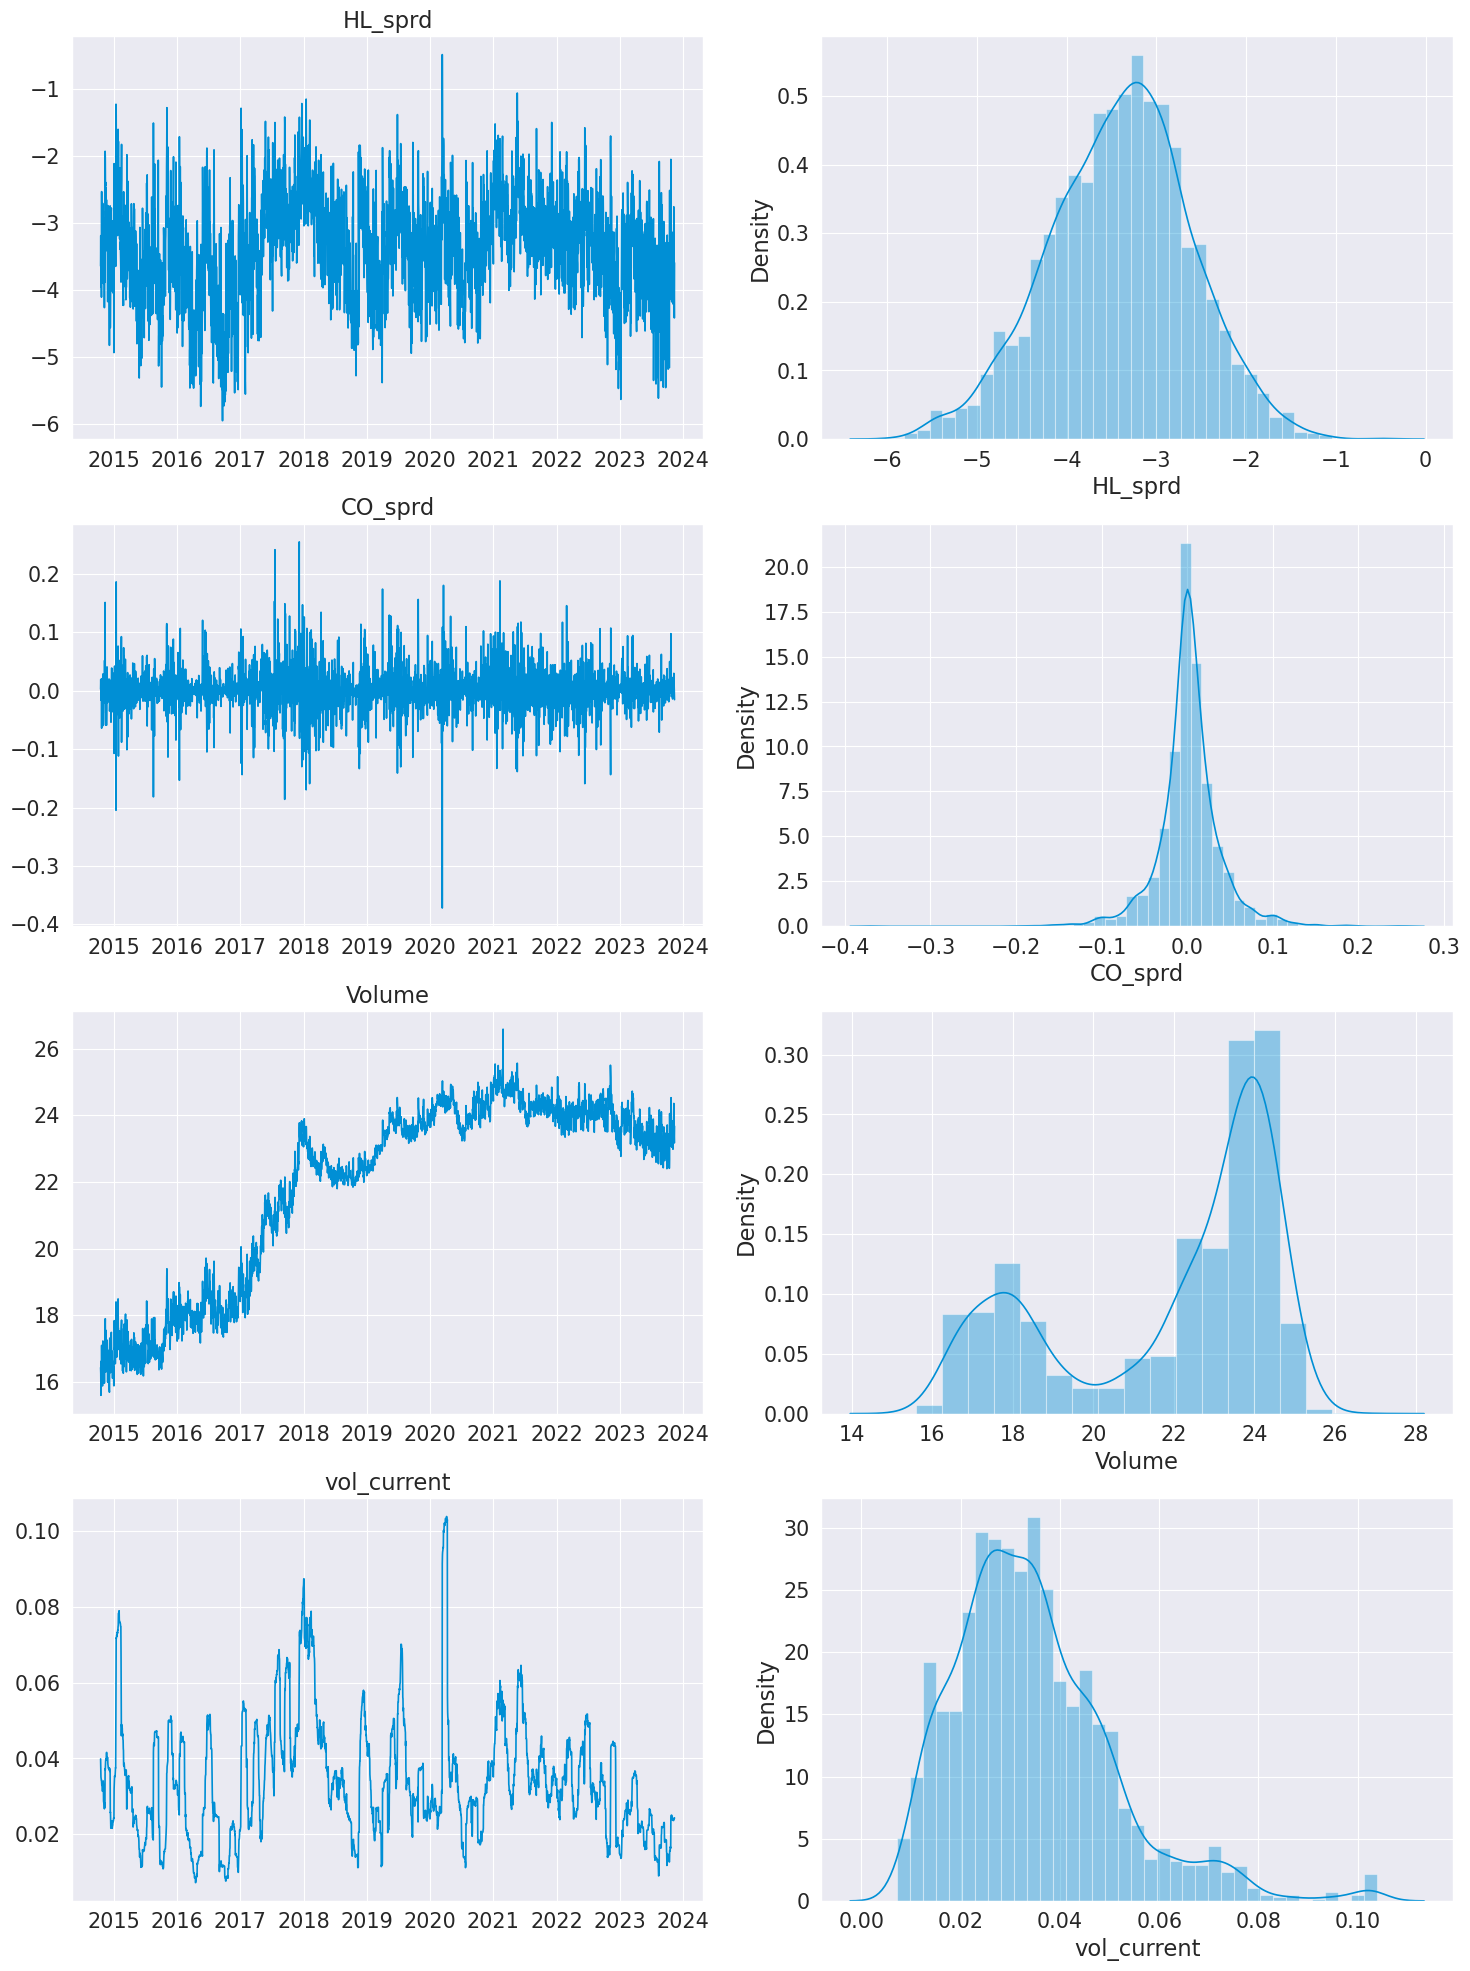

In [ ]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()

    plt.show();

#### 4.6.2. 输入 Reshaping


这里的预测是使用 4 个输入变量来预测未来 7 天的波动率 (`vol_future`) 列：
1. `HL_sprd`
2. `CO_sprd`
3. `Volume`
4. `vol_current`

输入Reshaping是这些多元 LSTM 的核心。 一般来说，LSTM 的输入应采用以下形式：


**`[batch_size, n_past, input_dims]`**



其中：

- **`batch_size`** 是每个批次中的样本数量
- **`n_past`** 是用于预测的过去时间步数。
- **`input_dims`** 是输入特征的数量

In [ ]:
input_df = df[features]
X_train = input_df.loc[train_idx]

In [ ]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-10-17 00:00:00+00:00 -3.638567  0.002618  16.425632     0.039872
2014-10-18 00:00:00+00:00 -3.185630  0.019444  16.250597     0.037566
2014-10-19 00:00:00+00:00 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 00:00:00+00:00 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 00:00:00+00:00 -3.487953  0.010601  16.467971     0.034362

In [ ]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-10-17 00:00:00+00:00 -3.638567  0.002618  16.425632     0.039872
2014-10-18 00:00:00+00:00 -3.185630  0.019444  16.250597     0.037566
2014-10-19 00:00:00+00:00 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 00:00:00+00:00 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 00:00:00+00:00 -3.487953  0.010601  16.467971     0.034362

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2014-10-17 00:00:00+00:00 to 2022-10-14 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2920 non-null   float64
 1   CO_sprd      2920 non-null   float64
 2   Volume       2920 non-null   float64
 3   vol_current  2920 non-null   float64
dtypes: float64(4)
memory usage: 114.1 KB


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3315 entries, 2014-10-17 00:00:00+00:00 to 2023-11-13 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      3315 non-null   float64
 1   CO_sprd      3315 non-null   float64
 2   Volume       3315 non-null   float64
 3   vol_current  3315 non-null   float64
dtypes: float64(4)
memory usage: 258.5 KB


In [ ]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

### 4.7。 带 Dropout 的多元 2 层双向 LSTM

第一个多元 LSTM 模型相对简单，具有 2 个双向 LSTM 隐藏层（与上面的单变量结构非常相似）。 不过，我还会在其间添加 Dropout 层。 拥有更多特征意味着模型更容易出现**过度拟合**，而 Dropout 层可以帮助减少这种情况。

In [ ]:
tf.keras.backend.clear_session()

np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

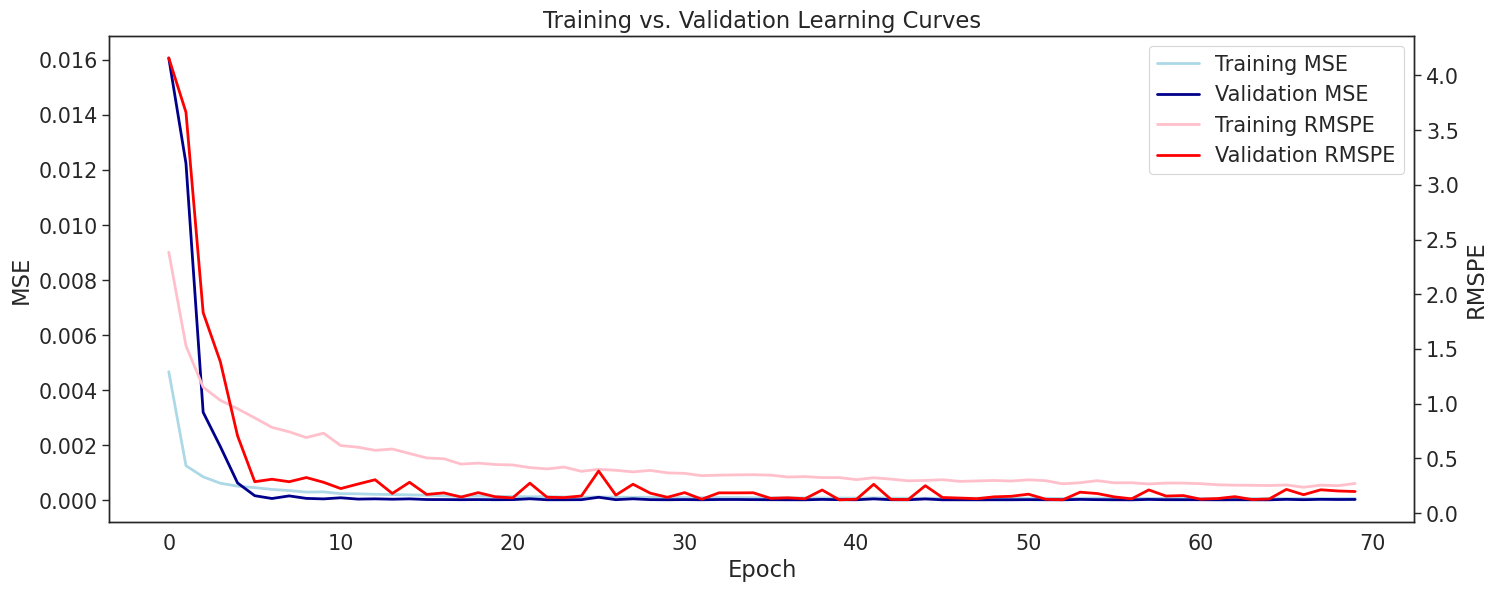

In [ ]:
viz_train_val_metrics(lstm_5_res)

In [ ]:
lstm_5_preds = forecast_multi(lstm_5, val_idx)
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 2s 10ms/step


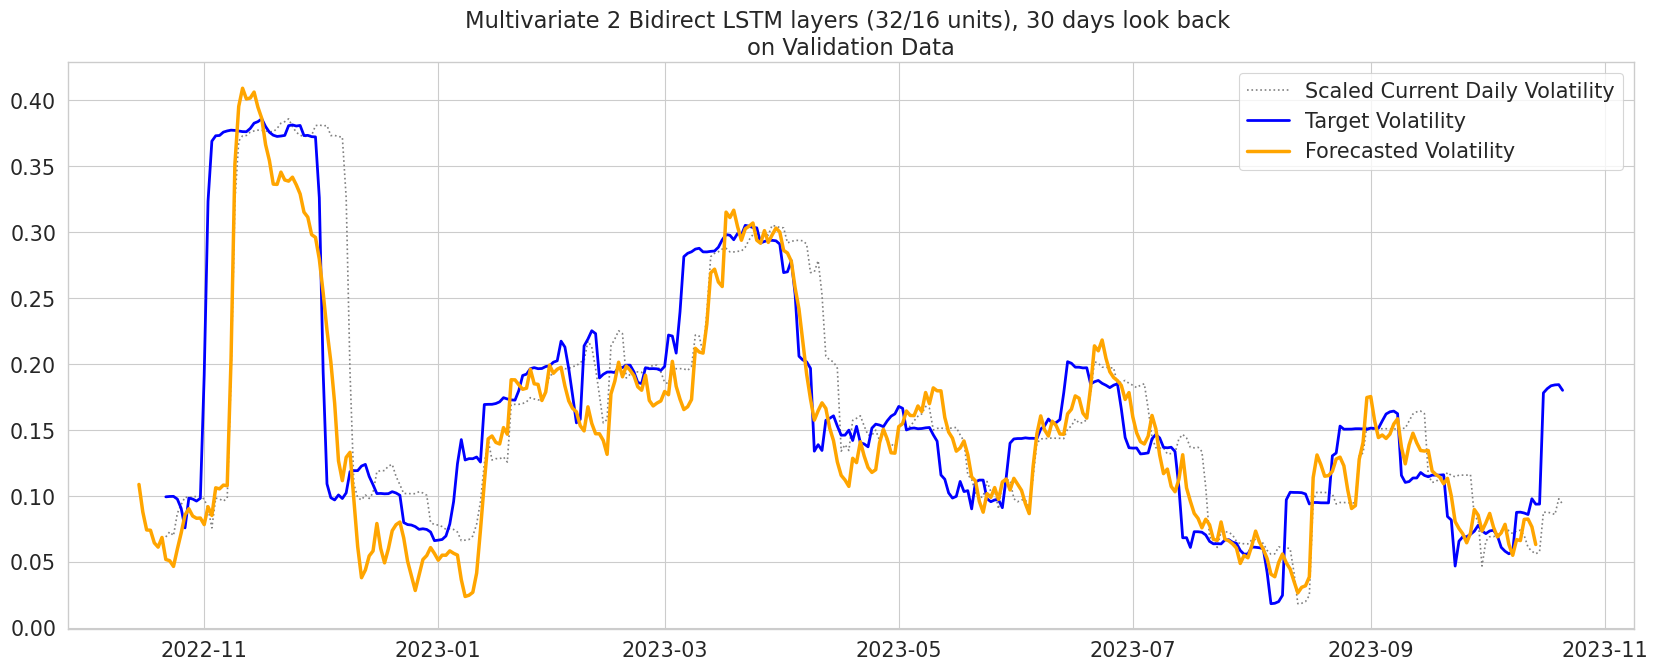

In [ ]:
viz_model(y_val_scaled, lstm_5_preds_scaled,
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
plt.show();

In [ ]:
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  \
0                                                 Mean Baseline   
1                                 Random Walk Naive Forecasting   
2                        GARCH(1,1), Constant Mean, Normal Dist   
3        Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4               Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5           Bootstrap TARCH(2, 1, 2), Constant Mean, Skewt Dist   
6                              LSTM 1 layer 20 units, n_past=14   
7               2 layers Bidirect LSTM (32/16 units), n_past=30   
8  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
9  Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   

   Validation RMSPE  Validation RMSE  
0          2.271653         0.160575  
1          0.503847         0.062056  
2          0.517396         0.103361  
3          0.327460         0.062464  
4          0.453947         0.064456  
5          0.405107         0.063683  
6          0.568074         0.082555  
7          0.426800         0.081528  
8          0.393906         0.078348  
9          0.311500         0.079103

### 4.8。 多元三层双向 LSTM

接下来，我将添加更多 LSTM 层，看看这是否有助于提高性能。

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

lstm_6 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           35328     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 64)            41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [149]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

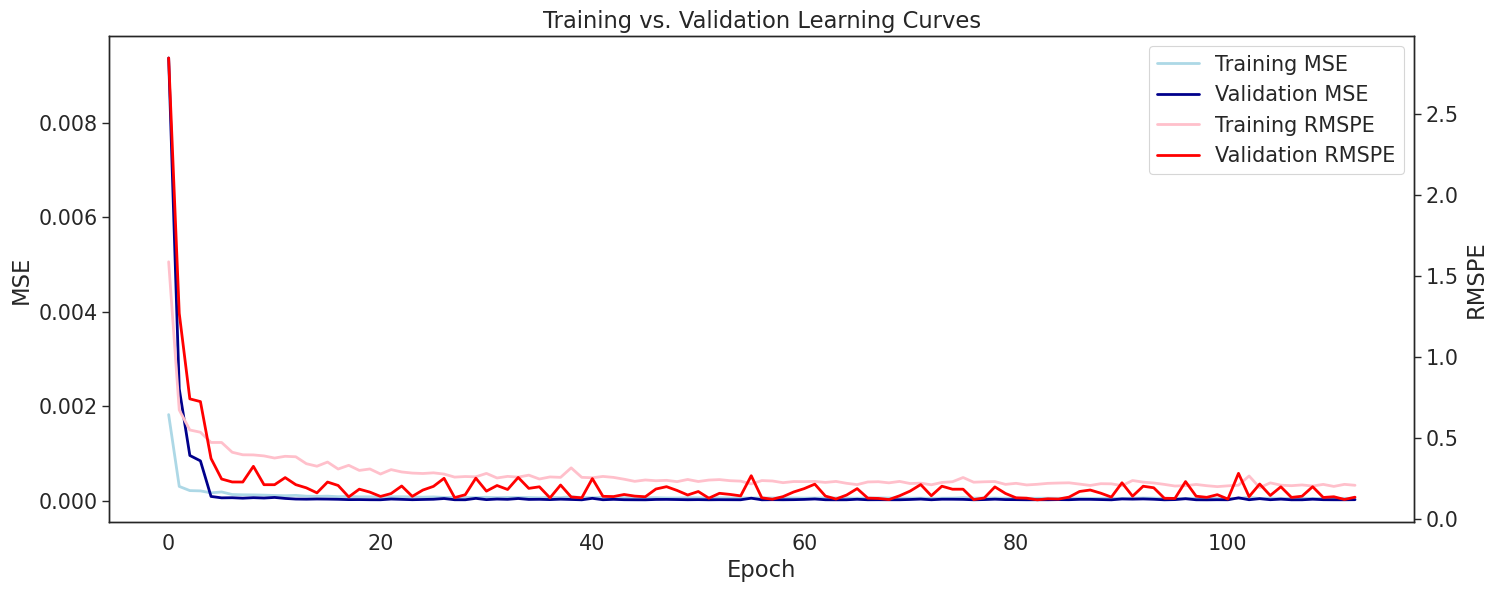

In [150]:
viz_train_val_metrics(lstm_6_res)

In [152]:
lstm_6_preds = forecast_multi(lstm_6, val_idx)
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

12/12 [==============================] - 4s 36ms/step


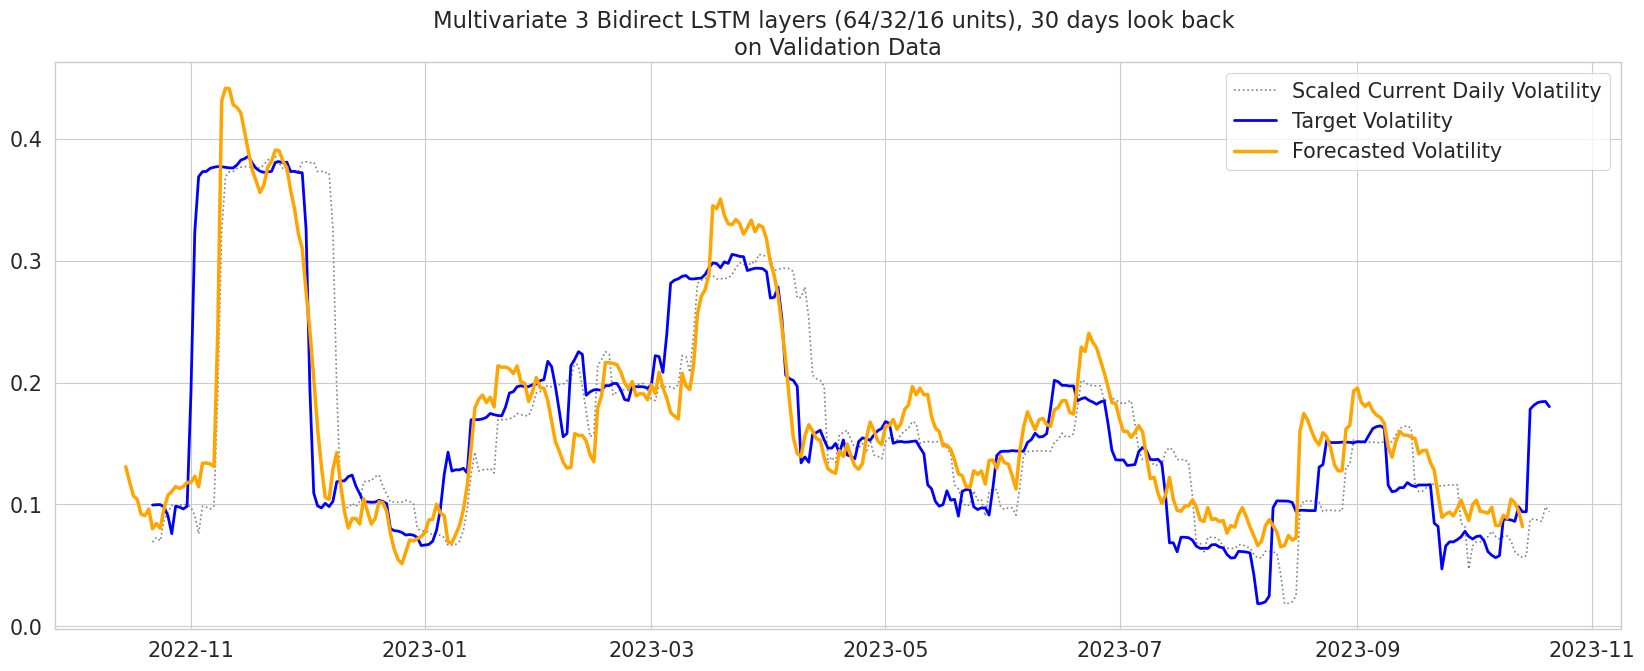

In [153]:
viz_model(y_val_scaled, lstm_6_preds_scaled,
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")
plt.show();

In [154]:
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

Model  \
0                                                     Mean Baseline   
1                                     Random Walk Naive Forecasting   
2                            GARCH(1,1), Constant Mean, Normal Dist   
3            Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                   Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5               Bootstrap TARCH(2, 1, 2), Constant Mean, Skewt Dist   
6                                  LSTM 1 layer 20 units, n_past=14   
7                   2 layers Bidirect LSTM (32/16 units), n_past=30   
8      1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
9      Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
10  Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   

    Validation RMSPE  Validation RMSE  
0           2.271653         0.160575  
1           0.503847         0.062056  
2           0.517396         0.103361  
3           0.327460         0.062464  
4           0.453947         0.064456  
5           0.405107         0.063683  
6           0.568074         0.082555  
7           0.426800         0.081528  
8           0.393906         0.078348  
9           0.311500         0.079103  
10          0.401154         0.074838

### 4.8. Multivariate 4-Layered Bidirectional LSTM

In [155]:
tf.keras.backend.clear_session()

np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

lstm_7 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 256)           136192    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 128)           164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [156]:
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

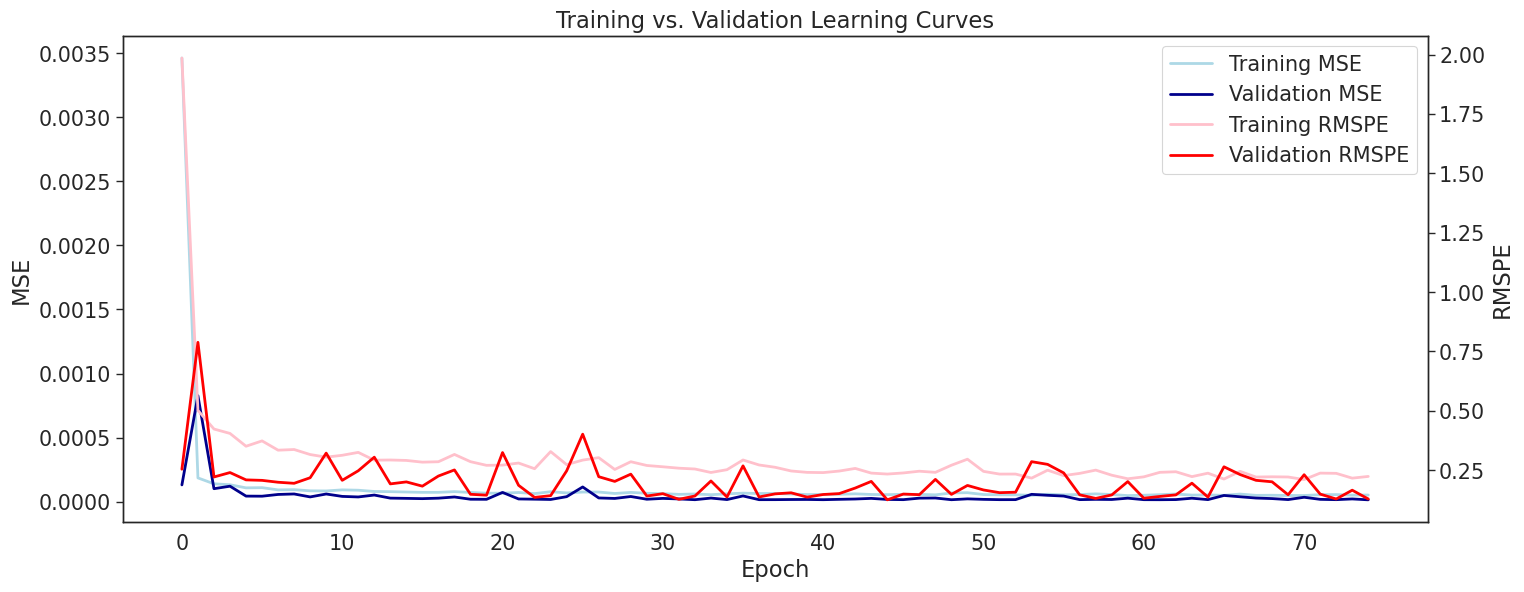

In [157]:
viz_train_val_metrics(lstm_7_res)

In [159]:
lstm_7_preds = forecast_multi(lstm_7, val_idx)
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

12/12 [==============================] - 4s 44ms/step


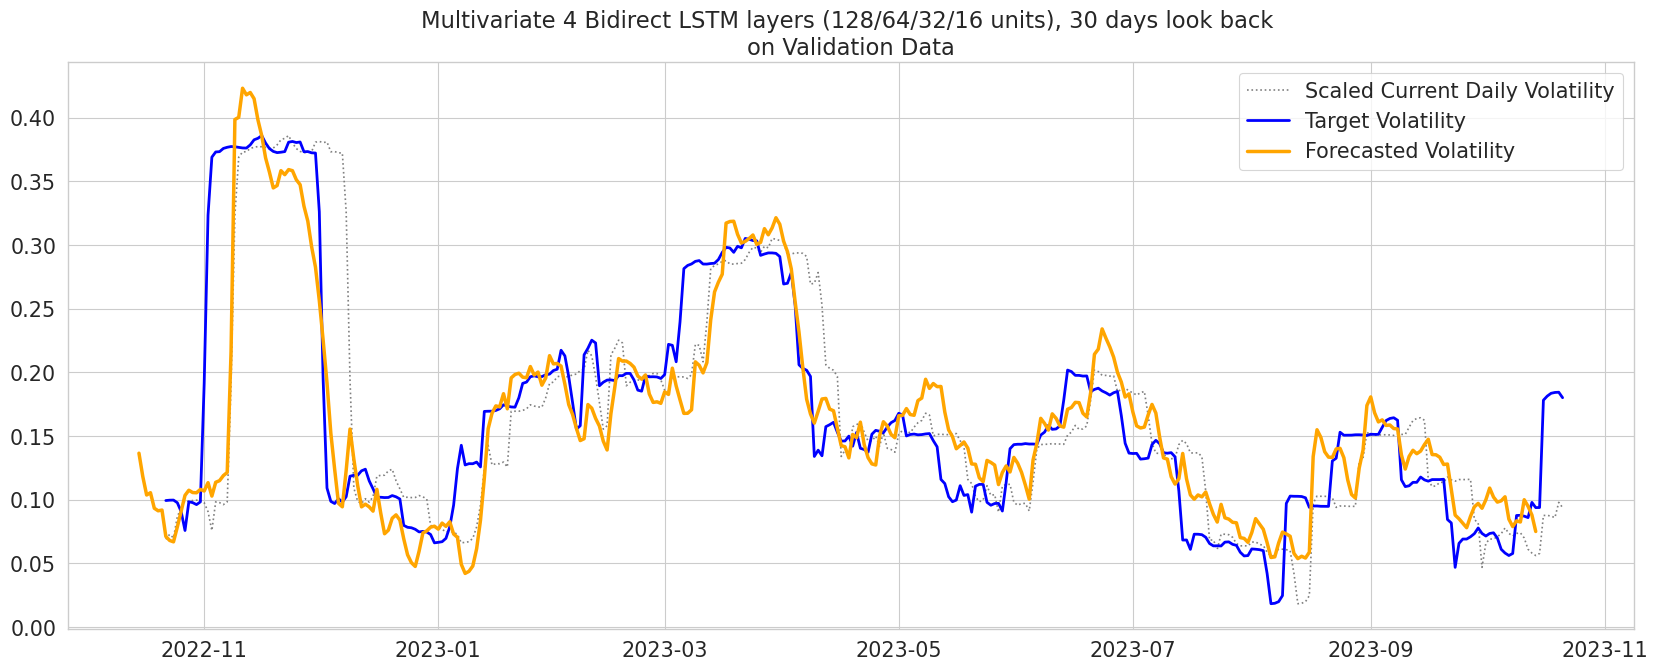

In [160]:
viz_model(y_val_scaled, lstm_7_preds_scaled,
          f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), {n_past} days look back")
plt.show();

In [161]:
log_perf(y_val_scaled, lstm_7_preds_scaled,
         f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                                                   Mean Baseline   
1                                                   Random Walk Naive Forecasting   
2                                          GARCH(1,1), Constant Mean, Normal Dist   
3                          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                             Bootstrap TARCH(2, 1, 2), Constant Mean, Skewt Dist   
6                                                LSTM 1 layer 20 units, n_past=14   
7                                 2 layers Bidirect LSTM (32/16 units), n_past=30   
8                    1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
9                    Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
10                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   
11  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=30, batch=64   

    Validation RMSPE  Validation RMSE  
0           2.271653         0.160575  
1           0.503847         0.062056  
2           0.517396         0.103361  
3           0.327460         0.062464  
4           0.453947         0.064456  
5           0.405107         0.063683  
6           0.568074         0.082555  
7           0.426800         0.081528  
8           0.393906         0.078348  
9           0.311500         0.079103  
10          0.401154         0.074838  
11          0.346896         0.075415